In [1]:

import os
import cv2
import numpy as np
import pandas as pd
from skimage import io, img_as_float
from skimage.filters import sobel
from skimage.feature import graycomatrix, graycoprops, local_binary_pattern
from scipy.stats import skew, kurtosis, entropy
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
import seaborn as sns
import joblib
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


In [5]:


dataset_dir = r"C:\Users\Sona\Downloads\official_document"
output_dir = r"C:\Users\Sona\Downloads\tracefinder_outputs"

models_dir = os.path.join(output_dir, "models")
results_dir = os.path.join(output_dir, "results")
plots_dir = os.path.join(output_dir, "plots")
features_dir = os.path.join(output_dir, "features")

# Create directories
for directory in [models_dir, results_dir, plots_dir, features_dir]:
    os.makedirs(directory, exist_ok=True)

print("\n" + "="*70)
print("PATH CONFIGURATION")
print("="*70)

# Verify dataset exists
if not os.path.exists(dataset_dir):
    raise FileNotFoundError(f" Dataset not found at: {dataset_dir}")
else:
    print(f" Dataset found at: {dataset_dir}")
    
# Count scanner folders
scanner_folders = [f for f in os.listdir(dataset_dir) 
                   if os.path.isdir(os.path.join(dataset_dir, f))]
print(f"\n Found {len(scanner_folders)} scanner folders:")
total_files = 0

for folder in sorted(scanner_folders):
    img_count = 0
    for root, _, files in os.walk(os.path.join(dataset_dir, folder)):
        img_count += len([f for f in files if f.lower().endswith(('.tif', '.jpg', '.png', '.jpeg'))])
    total_files += img_count
    print(f"    {folder:20s} : {img_count:4d} images")

print(f"\n Total images in dataset: {total_files}")
print(f" Output directories created at: {output_dir}")
print("="*70 + "\n")



PATH CONFIGURATION
 Dataset found at: C:\Users\Sona\Downloads\official_document

 Found 12 scanner folders:
    Canon120-1           :  200 images
    Canon120-2           :  200 images
    Canon220             :  200 images
    Canon9000-1          :  200 images
    Canon9000-2          :  200 images
    EpsonV370-1          :  200 images
    EpsonV370-2          :  200 images
    EpsonV39-1           :  200 images
    EpsonV39-2           :  200 images
    EpsonV550            :  200 images
    HP                   :  200 images
    plots                :    2 images

 Total images in dataset: 2202
 Output directories created at: C:\Users\Sona\Downloads\tracefinder_outputs



In [3]:
def load_gray(img_path, size=(256, 256)):
    try:
        img = io.imread(img_path, as_gray=True)
        img = img_as_float(img)
        return cv2.resize(img, size, interpolation=cv2.INTER_AREA)
    except Exception as e:
        print(f"  Error loading {img_path}: {e}")
        return None


def extract_features(img, file_path, scanner_id="unknown"):
    if img is None:
        return None
    
    h, w = img.shape
    aspect_ratio = w / h
    file_size_kb = os.path.getsize(file_path) / 1024
    pixels = img.flatten()

    # Basic statistics
    mean_intensity = np.mean(pixels)
    std_intensity = np.std(pixels)
    skewness = skew(pixels)
    kurt_val = kurtosis(pixels)
    ent = entropy(np.histogram(pixels, bins=256, range=(0, 1))[0] + 1e-6)

    # Edge density
    edges = sobel(img)
    edge_density = np.mean(edges > 0.1)

    # Texture (GLCM)
    img_uint8 = (img * 255).astype(np.uint8)
    glcm = graycomatrix(img_uint8, [1], [0], levels=256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]

    # LBP entropy
    lbp = local_binary_pattern(img_uint8, P=8, R=1, method="uniform")
    lbp_hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, 59), range=(0, 58))
    lbp_hist = lbp_hist.astype("float")
    lbp_hist /= (lbp_hist.sum() + 1e-6)
    lbp_entropy = entropy(lbp_hist + 1e-6)

    # Frequency domain (FFT)
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)
    fft_mean = np.mean(magnitude_spectrum)
    fft_std = np.std(magnitude_spectrum)

    return {
        "class_label": scanner_id,
        "file_size_kb": file_size_kb,
        "mean_intensity": mean_intensity,
        "std_intensity": std_intensity,
        "skewness": skewness,
        "kurtosis": kurt_val,
        "entropy": ent,
        "edge_density": edge_density,
        "contrast": contrast,
        "homogeneity": homogeneity,
        "energy": energy,
        "correlation": correlation,
        "lbp_entropy": lbp_entropy,
        "fft_mean": fft_mean,
        "fft_std": fft_std,
    }


def process_image_and_append(df, img_path, scanner_id="unknown"):
    img = load_gray(img_path)
    if img is not None:
        features = extract_features(img, img_path, scanner_id)
        if features is not None:
            df.loc[len(df)] = features
    return df

print("Helper functions defined successfully!")


Helper functions defined successfully!


In [4]:
print("\n" + "="*70)
print("FEATURE EXTRACTION STARTED")
print("="*70 + "\n")

# Initialize metadata dataframe
columns = [
    "class_label", "file_size_kb", "mean_intensity", "std_intensity",
    "skewness", "kurtosis", "entropy", "edge_density",
    "contrast", "homogeneity", "energy", "correlation",
    "lbp_entropy", "fft_mean", "fft_std"
]

metadata = pd.DataFrame(columns=columns)

# Process all images
processed_count = 0
error_count = 0

for root, dirs, files in os.walk(dataset_dir):
    for file in files:
        if file.lower().endswith(('.tif', '.jpg', '.png', '.jpeg')):
            img_path = os.path.join(root, file)
            relative_path = os.path.relpath(img_path, dataset_dir)
            scanner_id = relative_path.split(os.sep)[0]
            
            # Process image
            old_len = len(metadata)
            metadata = process_image_and_append(metadata, img_path, scanner_id)
            
            if len(metadata) > old_len:
                processed_count += 1
                if processed_count % 100 == 0:
                    print(f" Processed {processed_count} images...")
            else:
                error_count += 1

# Clean data
metadata = metadata.dropna()

print(f"\n" + "="*70)
print(f" Feature extraction complete!")
print(f"   Total processed: {processed_count}")
print(f"   Errors: {error_count}")
print(f"   Valid samples: {len(metadata)}")
print("="*70 + "\n")

# Save extracted features
features_csv_path = os.path.join(features_dir, "extracted_features.csv")
metadata.to_csv(features_csv_path, index=False)
print(f" Features saved to: {features_csv_path}\n")

# Display class distribution
print(" Class Distribution:")
print(metadata["class_label"].value_counts().sort_index())
print()



FEATURE EXTRACTION STARTED

 Processed 100 images...
 Processed 200 images...
 Processed 300 images...
 Processed 400 images...
 Processed 500 images...
 Processed 600 images...
 Processed 700 images...
 Processed 800 images...
 Processed 900 images...
 Processed 1000 images...
 Processed 1100 images...
 Processed 1200 images...
 Processed 1300 images...
 Processed 1400 images...
 Processed 1500 images...
 Processed 1600 images...
 Processed 1700 images...
 Processed 1800 images...
 Processed 1900 images...
 Processed 2000 images...
 Processed 2100 images...
 Processed 2200 images...

 Feature extraction complete!
   Total processed: 2200
   Errors: 0
   Valid samples: 2200

 Features saved to: C:\Users\Sona\Downloads\tracefinder_outputs\features\extracted_features.csv

 Class Distribution:
class_label
Canon120-1     200
Canon120-2     200
Canon220       200
Canon9000-1    200
Canon9000-2    200
EpsonV370-1    200
EpsonV370-2    200
EpsonV39-1     200
EpsonV39-2     200
EpsonV550     

In [5]:
print("="*70)
print("DATA PREPARATION")
print("="*70 + "\n")

# Separate features and labels
X = metadata.drop(columns=["class_label"], errors='ignore')
y = metadata["class_label"]

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

print(f" Features shape: {X.shape}")
print(f" Labels shape: {y.shape}")
print(f" Number of classes: {len(le.classes_)}")
print(f" Classes: {list(le.classes_)}\n")

# Handle class imbalance with SMOTE
print(" Applying SMOTE for class balancing...")
smote = SMOTE(random_state=42)
X_res, y_res = smote.fit_resample(X, y_encoded)

print(f" Resampled dataset shape: {X_res.shape}")
print(f" Class distribution after SMOTE:")
print(pd.Series(y_res).value_counts().sort_index())
print()

DATA PREPARATION

 Features shape: (2200, 14)
 Labels shape: (2200,)
 Number of classes: 11
 Classes: ['Canon120-1', 'Canon120-2', 'Canon220', 'Canon9000-1', 'Canon9000-2', 'EpsonV370-1', 'EpsonV370-2', 'EpsonV39-1', 'EpsonV39-2', 'EpsonV550', 'HP']

 Applying SMOTE for class balancing...
 Resampled dataset shape: (2200, 14)
 Class distribution after SMOTE:
0     200
1     200
2     200
3     200
4     200
5     200
6     200
7     200
8     200
9     200
10    200
Name: count, dtype: int64



In [6]:
X_train, X_test, y_train, y_test = train_test_split(
    X_res, y_res, test_size=0.2, random_state=42, stratify=y_res
)

print(f" Training set: {X_train.shape[0]} samples")
print(f" Test set: {X_test.shape[0]} samples\n")

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(" Feature scaling complete!\n")

 Training set: 1760 samples
 Test set: 440 samples

 Feature scaling complete!



In [7]:
print("="*70)
print("SVM MODEL TRAINING")
print("="*70 + "\n")

# Grid Search for SVM
svm_params = {
    'C': [0.5, 1, 5, 10],
    'gamma': ['scale', 0.01, 0.001],
    'kernel': ['rbf', 'poly']
}

print(" Performing Grid Search for SVM hyperparameters...")
print(f"   Parameter grid: {svm_params}\n")

svm = GridSearchCV(
    SVC(class_weight='balanced', random_state=42),
    svm_params, 
    cv=3, 
    n_jobs=-1, 
    verbose=1,
    scoring='accuracy'
)

svm.fit(X_train_scaled, y_train)

print(f"\n Best SVM Parameters: {svm.best_params_}")
print(f" Best CV Score: {svm.best_score_:.4f}\n")

# Predictions
y_pred_svm = svm.predict(X_test_scaled)
svm_acc = accuracy_score(y_test, y_pred_svm)

print(f" SVM Test Accuracy: {svm_acc * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

SVM MODEL TRAINING

 Performing Grid Search for SVM hyperparameters...
   Parameter grid: {'C': [0.5, 1, 5, 10], 'gamma': ['scale', 0.01, 0.001], 'kernel': ['rbf', 'poly']}

Fitting 3 folds for each of 24 candidates, totalling 72 fits

 Best SVM Parameters: {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}
 Best CV Score: 0.3386

 SVM Test Accuracy: 30.68%

Classification Report:
              precision    recall  f1-score   support

  Canon120-1       0.07      0.03      0.04        40
  Canon120-2       0.14      0.23      0.17        40
    Canon220       0.06      0.05      0.05        40
 Canon9000-1       0.00      0.00      0.00        40
 Canon9000-2       0.14      0.20      0.16        40
 EpsonV370-1       0.54      0.55      0.54        40
 EpsonV370-2       0.45      0.50      0.48        40
  EpsonV39-1       0.12      0.15      0.13        40
  EpsonV39-2       0.15      0.07      0.10        40
   EpsonV550       0.48      0.60      0.53        40
          HP       1.00      1

In [8]:
print("\n" + "="*70)
print("RANDOM FOREST MODEL TRAINING")
print("="*70 + "\n")

# Grid Search for Random Forest
rf_params = {
    'n_estimators': [200, 300, 400],
    'max_depth': [15, 20, 25],
    'min_samples_split': [2, 5, 10],
    'class_weight': ['balanced']
}

print("Performing Grid Search for Random Forest hyperparameters...")
print(f"   Parameter grid: {rf_params}\n")

rf = GridSearchCV(
    RandomForestClassifier(random_state=42),
    rf_params, 
    cv=3, 
    n_jobs=-1, 
    verbose=1,
    scoring='accuracy'
)

rf.fit(X_train, y_train)

print(f"\n Best RF Parameters: {rf.best_params_}")
print(f"Best CV Score: {rf.best_score_:.4f}\n")

# Predictions
y_pred_rf = rf.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)

print(f" Random Forest Test Accuracy: {rf_acc * 100:.2f}%\n")
print("Classification Report:")
print(classification_report(y_test, y_pred_rf, target_names=le.classes_))


RANDOM FOREST MODEL TRAINING

Performing Grid Search for Random Forest hyperparameters...
   Parameter grid: {'n_estimators': [200, 300, 400], 'max_depth': [15, 20, 25], 'min_samples_split': [2, 5, 10], 'class_weight': ['balanced']}

Fitting 3 folds for each of 27 candidates, totalling 81 fits

 Best RF Parameters: {'class_weight': 'balanced', 'max_depth': 25, 'min_samples_split': 10, 'n_estimators': 200}
Best CV Score: 0.3932

 Random Forest Test Accuracy: 35.45%

Classification Report:
              precision    recall  f1-score   support

  Canon120-1       0.02      0.03      0.02        40
  Canon120-2       0.02      0.03      0.02        40
    Canon220       0.42      0.28      0.33        40
 Canon9000-1       0.13      0.12      0.13        40
 Canon9000-2       0.19      0.17      0.18        40
 EpsonV370-1       0.41      0.28      0.33        40
 EpsonV370-2       0.44      0.60      0.51        40
  EpsonV39-1       0.29      0.30      0.29        40
  EpsonV39-2       


CREATING VISUALIZATIONS



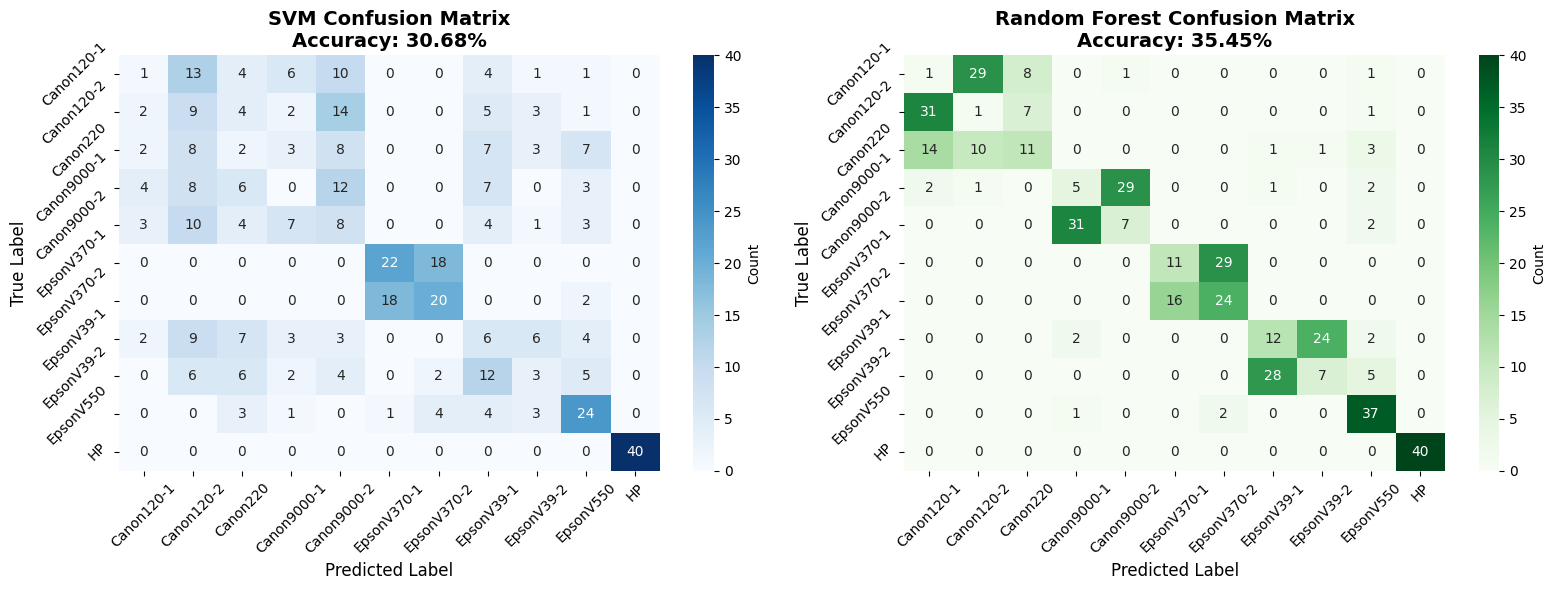

 Confusion matrices saved to: C:\Users\Sona\Downloads\tracefinder_outputs\plots\confusion_matrices.png



In [9]:
print("\n" + "="*70)
print("CREATING VISUALIZATIONS")
print("="*70 + "\n")

# Confusion Matrices
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# SVM Confusion Matrix
cm_svm = confusion_matrix(y_test, y_pred_svm)
sns.heatmap(cm_svm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_,
            ax=axes[0], cbar_kws={'label': 'Count'})
axes[0].set_title(f'SVM Confusion Matrix\nAccuracy: {svm_acc*100:.2f}%', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Predicted Label', fontsize=12)
axes[0].set_ylabel('True Label', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].tick_params(axis='y', rotation=45)

# Random Forest Confusion Matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_,
            ax=axes[1], cbar_kws={'label': 'Count'})
axes[1].set_title(f'Random Forest Confusion Matrix\nAccuracy: {rf_acc*100:.2f}%', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Predicted Label', fontsize=12)
axes[1].set_ylabel('True Label', fontsize=12)
axes[1].tick_params(axis='x', rotation=45)
axes[1].tick_params(axis='y', rotation=45)

plt.tight_layout()
cm_path = os.path.join(plots_dir, "confusion_matrices.png")
plt.savefig(cm_path, dpi=300, bbox_inches='tight')
plt.show()

print(f" Confusion matrices saved to: {cm_path}\n")

FEATURE IMPORTANCE ANALYSIS

 Top 10 Most Important Features:
       feature  importance
  file_size_kb    0.204388
        energy    0.146482
   lbp_entropy    0.134712
   homogeneity    0.087750
       entropy    0.077516
mean_intensity    0.057231
      skewness    0.041996
      kurtosis    0.039073
       fft_std    0.038749
  edge_density    0.037187



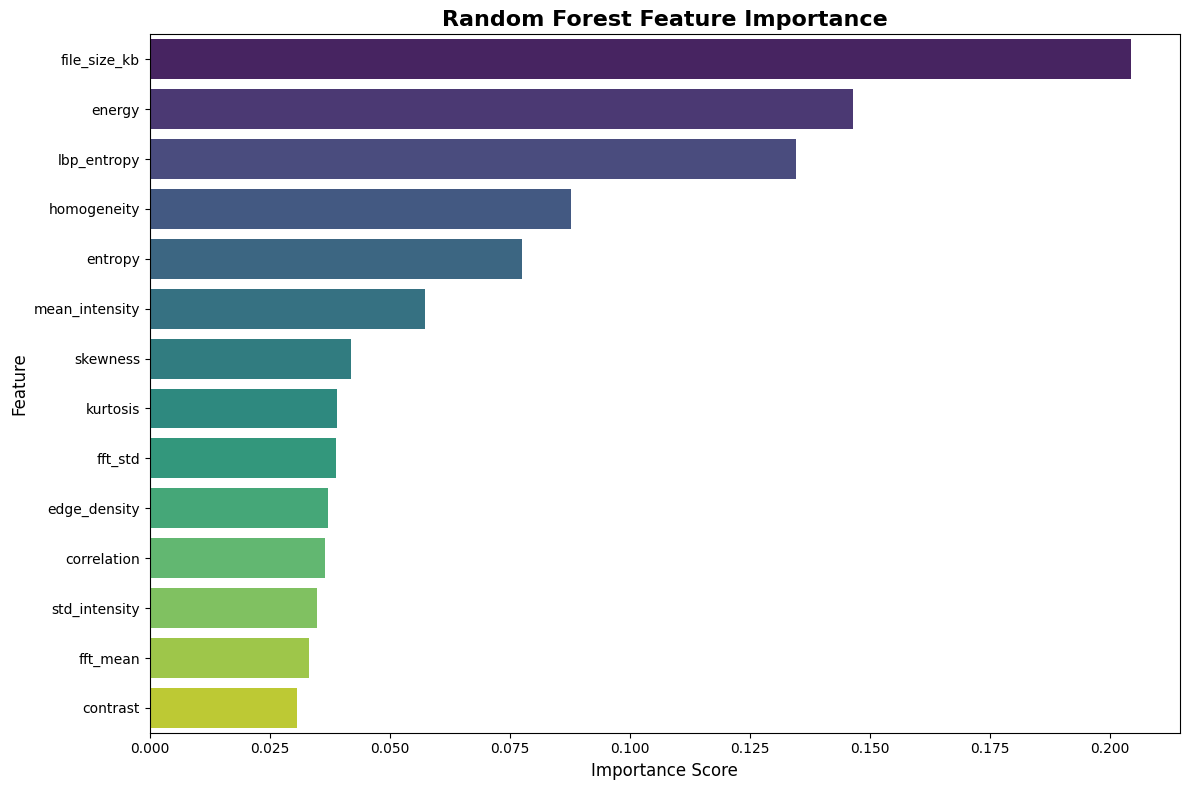

 Feature importance plot saved to: C:\Users\Sona\Downloads\tracefinder_outputs\plots\feature_importance.png



In [10]:
print("="*70)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*70 + "\n")

# Get feature importance from Random Forest
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.best_estimator_.feature_importances_
}).sort_values('importance', ascending=False)

print(" Top 10 Most Important Features:")
print(feature_importance.head(10).to_string(index=False))
print()

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(data=feature_importance, y='feature', x='importance', palette='viridis')
plt.title('Random Forest Feature Importance', fontsize=16, fontweight='bold')
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.tight_layout()
fi_path = os.path.join(plots_dir, "feature_importance.png")
plt.savefig(fi_path, dpi=300, bbox_inches='tight')
plt.show()

print(f" Feature importance plot saved to: {fi_path}\n")

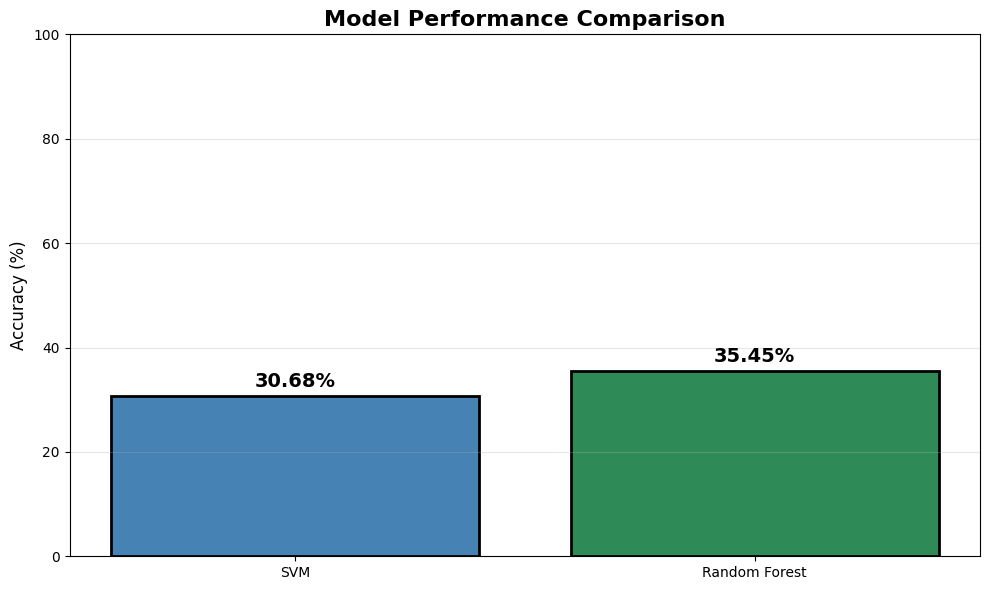

 Model comparison plot saved to: C:\Users\Sona\Downloads\tracefinder_outputs\plots\model_comparison.png



In [11]:
# Model performance comparison
performance_df = pd.DataFrame({
    'Model': ['SVM', 'Random Forest'],
    'Accuracy': [svm_acc * 100, rf_acc * 100],
    'Parameters': [str(svm.best_params_), str(rf.best_params_)]
})

plt.figure(figsize=(10, 6))
bars = plt.bar(performance_df['Model'], performance_df['Accuracy'], 
               color=['steelblue', 'seagreen'], edgecolor='black', linewidth=2)
plt.title('Model Performance Comparison', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy (%)', fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 1,
             f'{height:.2f}%', ha='center', va='bottom', 
             fontsize=14, fontweight='bold')

plt.tight_layout()
comp_path = os.path.join(plots_dir, "model_comparison.png")
plt.savefig(comp_path, dpi=300, bbox_inches='tight')
plt.show()

print(f" Model comparison plot saved to: {comp_path}\n")


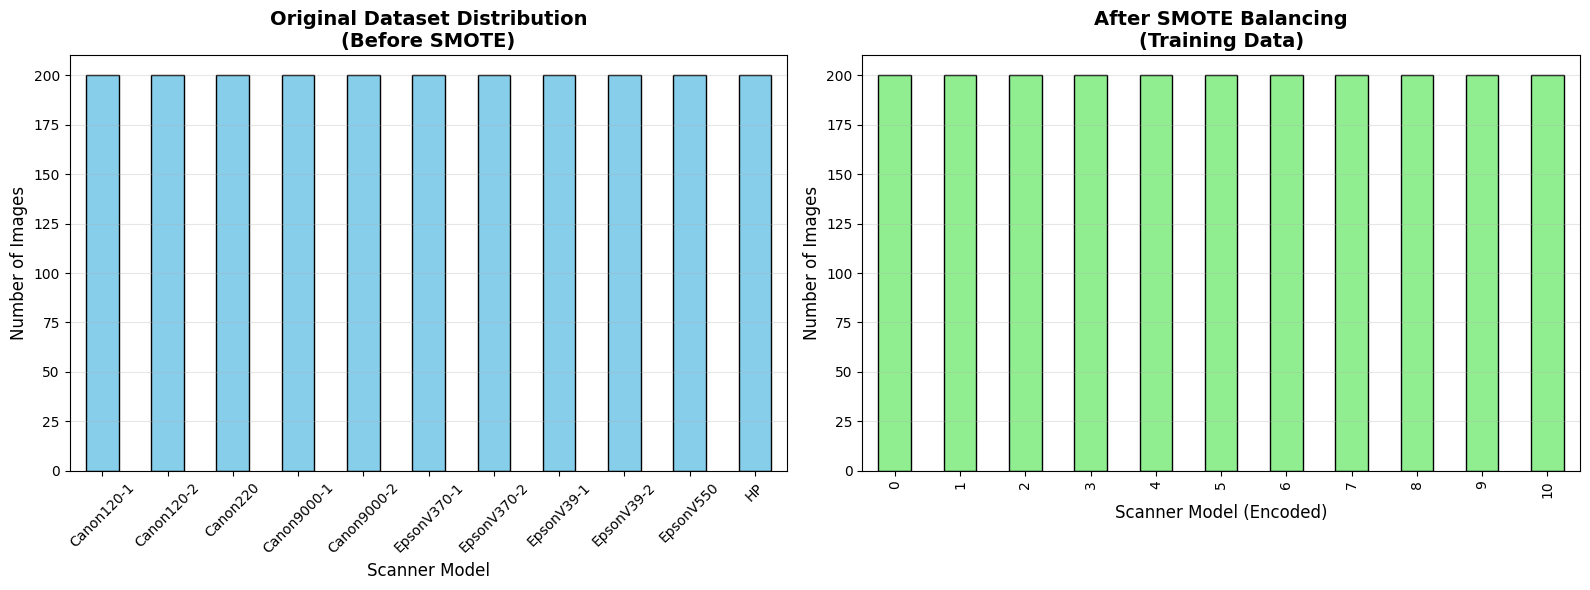

 Class distribution plots saved to: C:\Users\Sona\Downloads\tracefinder_outputs\plots\class_distribution.png



In [12]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Original distribution
metadata['class_label'].value_counts().sort_index().plot(
    kind='bar', ax=axes[0], color='skyblue', edgecolor='black'
)
axes[0].set_title('Original Dataset Distribution\n(Before SMOTE)', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Scanner Model', fontsize=12)
axes[0].set_ylabel('Number of Images', fontsize=12)
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(axis='y', alpha=0.3)

# After SMOTE
pd.Series(y_res).value_counts().sort_index().plot(
    kind='bar', ax=axes[1], color='lightgreen', edgecolor='black'
)
axes[1].set_title('After SMOTE Balancing\n(Training Data)', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Scanner Model (Encoded)', fontsize=12)
axes[1].set_ylabel('Number of Images', fontsize=12)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
dist_path = os.path.join(plots_dir, "class_distribution.png")
plt.savefig(dist_path, dpi=300, bbox_inches='tight')
plt.show()

print(f" Class distribution plots saved to: {dist_path}\n")


In [13]:
print("="*70)
print("SAVING MODELS AND RESULTS")
print("="*70 + "\n")

# Save trained models
svm_model_path = os.path.join(models_dir, "svm_model.pkl")
rf_model_path = os.path.join(models_dir, "rf_model.pkl")
scaler_path = os.path.join(models_dir, "scaler.pkl")
le_path = os.path.join(models_dir, "label_encoder.pkl")

joblib.dump(svm.best_estimator_, svm_model_path)
joblib.dump(rf.best_estimator_, rf_model_path)
joblib.dump(scaler, scaler_path)
joblib.dump(le, le_path)

print(f" SVM model saved to: {svm_model_path}")
print(f" Random Forest model saved to: {rf_model_path}")
print(f"Scaler saved to: {scaler_path}")
print(f" Label encoder saved to: {le_path}\n")

# Save classification reports
svm_report_path = os.path.join(results_dir, "classification_report_svm.txt")
rf_report_path = os.path.join(results_dir, "classification_report_rf.txt")

with open(svm_report_path, "w") as f:
    f.write("="*70 + "\n")
    f.write("SVM CLASSIFICATION REPORT\n")
    f.write("="*70 + "\n\n")
    f.write(f"Test Accuracy: {svm_acc * 100:.2f}%\n")
    f.write(f"Best Parameters: {svm.best_params_}\n\n")
    f.write(classification_report(y_test, y_pred_svm, target_names=le.classes_))

with open(rf_report_path, "w") as f:
    f.write("="*70 + "\n")
    f.write("RANDOM FOREST CLASSIFICATION REPORT\n")
    f.write("="*70 + "\n\n")
    f.write(f"Test Accuracy: {rf_acc * 100:.2f}%\n")
    f.write(f"Best Parameters: {rf.best_params_}\n\n")
    f.write(classification_report(y_test, y_pred_rf, target_names=le.classes_))

print(f" SVM report saved to: {svm_report_path}")
print(f" Random Forest report saved to: {rf_report_path}\n")

# Save performance summary
summary_path = os.path.join(results_dir, "performance_summary.csv")
performance_df.to_csv(summary_path, index=False)
print(f" Performance summary saved to: {summary_path}\n")

# Save feature importance
fi_csv_path = os.path.join(results_dir, "feature_importance.csv")
feature_importance.to_csv(fi_csv_path, index=False)
print(f" Feature importance saved to: {fi_csv_path}\n")

SAVING MODELS AND RESULTS

 SVM model saved to: C:\Users\Sona\Downloads\tracefinder_outputs\models\svm_model.pkl
 Random Forest model saved to: C:\Users\Sona\Downloads\tracefinder_outputs\models\rf_model.pkl
Scaler saved to: C:\Users\Sona\Downloads\tracefinder_outputs\models\scaler.pkl
 Label encoder saved to: C:\Users\Sona\Downloads\tracefinder_outputs\models\label_encoder.pkl

 SVM report saved to: C:\Users\Sona\Downloads\tracefinder_outputs\results\classification_report_svm.txt
 Random Forest report saved to: C:\Users\Sona\Downloads\tracefinder_outputs\results\classification_report_rf.txt

 Performance summary saved to: C:\Users\Sona\Downloads\tracefinder_outputs\results\performance_summary.csv

 Feature importance saved to: C:\Users\Sona\Downloads\tracefinder_outputs\results\feature_importance.csv



In [14]:
print("\n" + "="*70)
print("FINAL SUMMARY - EXECUTION COMPLETE")
print("="*70 + "\n")

print("DATASET STATISTICS:")
print(f"   • Total Images: {len(metadata)}")
print(f"   • Scanner Models: {len(le.classes_)}")
print(f"   • Features Extracted: {X.shape[1]}")
print(f"   • Training Samples: {len(X_train)}")
print(f"   • Test Samples: {len(X_test)}\n")

print("MODEL PERFORMANCE:")
print(f"   • SVM Accuracy: {svm_acc * 100:.2f}%")
print(f"   • Random Forest Accuracy: {rf_acc * 100:.2f}%")
best_model = "Random Forest" if rf_acc > svm_acc else "SVM"
best_acc = max(rf_acc, svm_acc)
print(f"   • Best Model: {best_model} ({best_acc * 100:.2f}%)\n")

print("OUTPUT FILES LOCATION:")
print(f"   • Models: {models_dir}")
print(f"   • Results: {results_dir}")
print(f"   • Plots: {plots_dir}")
print(f"   • Features: {features_dir}\n")

print(" TASKS COMPLETED:")
print("   ✓ Dataset Collection & Preprocessing")
print("   ✓ Feature Engineering & Extraction")
print("   ✓ Model Training & Hyperparameter Tuning")
print("   ✓ Model Evaluation & Visualization")
print("   ✓ Results Saved Successfully\n")



FINAL SUMMARY - EXECUTION COMPLETE

DATASET STATISTICS:
   • Total Images: 2200
   • Scanner Models: 11
   • Features Extracted: 14
   • Training Samples: 1760
   • Test Samples: 440

MODEL PERFORMANCE:
   • SVM Accuracy: 30.68%
   • Random Forest Accuracy: 35.45%
   • Best Model: Random Forest (35.45%)

OUTPUT FILES LOCATION:
   • Models: C:\Users\Sona\Downloads\tracefinder_outputs\models
   • Results: C:\Users\Sona\Downloads\tracefinder_outputs\results
   • Plots: C:\Users\Sona\Downloads\tracefinder_outputs\plots
   • Features: C:\Users\Sona\Downloads\tracefinder_outputs\features

 TASKS COMPLETED:
   ✓ Dataset Collection & Preprocessing
   ✓ Feature Engineering & Extraction
   ✓ Model Training & Hyperparameter Tuning
   ✓ Model Evaluation & Visualization
   ✓ Results Saved Successfully



In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


In [8]:
import os

base_dir = r"C:\Users\Sona\Downloads\official_document"

print("Checking folders inside:", base_dir)
for name in os.listdir(base_dir):
    print("-", name)


Checking folders inside: C:\Users\Sona\Downloads\official_document
- Canon120-1
- Canon120-2
- Canon220
- Canon9000-1
- Canon9000-2
- EpsonV370-1
- EpsonV370-2
- EpsonV39-1
- EpsonV39-2
- EpsonV550
- HP
- metadata.csv


In [11]:
import os
import pandas as pd

# Path to your main dataset folder
base_dir = r"C:\Users\Sona\Downloads\official_document"

# Prepare a list for image data
data = []

# Walk through all subfolders and files recursively
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.lower().endswith(('.jpg', '.jpeg', '.png', '.tif')):
            img_path = os.path.join(root, file)
            # The class label will be the first-level folder (e.g., 'Canon120-1')
            class_label = os.path.basename(os.path.dirname(root))
            data.append([img_path, class_label])

# Create DataFrame
metadata = pd.DataFrame(data, columns=['image_path', 'class_label'])

# Save to CSV
csv_path = os.path.join(base_dir, "metadata.csv")
metadata.to_csv(csv_path, index=False)

print(f"✅ CSV file created successfully: {csv_path}")
print("\nSample rows:")
print(metadata.head())
print("\nImages per class:")
print(metadata['class_label'].value_counts())


✅ CSV file created successfully: C:\Users\Sona\Downloads\official_document\metadata.csv

Sample rows:
                                          image_path class_label
0  C:\Users\Sona\Downloads\official_document\Cano...  Canon120-1
1  C:\Users\Sona\Downloads\official_document\Cano...  Canon120-1
2  C:\Users\Sona\Downloads\official_document\Cano...  Canon120-1
3  C:\Users\Sona\Downloads\official_document\Cano...  Canon120-1
4  C:\Users\Sona\Downloads\official_document\Cano...  Canon120-1

Images per class:
class_label
Canon120-1     200
Canon120-2     200
Canon220       200
Canon9000-1    200
Canon9000-2    200
EpsonV370-1    200
EpsonV370-2    200
EpsonV39-1     200
EpsonV39-2     200
EpsonV550      200
HP             200
Name: count, dtype: int64


In [12]:
import pandas as pd

metadata_path = r"C:\Users\Sona\Downloads\official_document\metadata.csv"
metadata = pd.read_csv(metadata_path)

print(metadata.head())
print(metadata['class_label'].value_counts())


                                          image_path class_label
0  C:\Users\Sona\Downloads\official_document\Cano...  Canon120-1
1  C:\Users\Sona\Downloads\official_document\Cano...  Canon120-1
2  C:\Users\Sona\Downloads\official_document\Cano...  Canon120-1
3  C:\Users\Sona\Downloads\official_document\Cano...  Canon120-1
4  C:\Users\Sona\Downloads\official_document\Cano...  Canon120-1
class_label
Canon120-1     200
Canon120-2     200
Canon220       200
Canon9000-1    200
Canon9000-2    200
EpsonV370-1    200
EpsonV370-2    200
EpsonV39-1     200
EpsonV39-2     200
EpsonV550      200
HP             200
Name: count, dtype: int64


STEP 1: DIAGNOSING LOW ACCURACY ISSUES

📊 CHECK 1: Dataset Statistics
----------------------------------------------------------------------
Total samples: 2200
Number of classes: 11
Samples per class:

class_label
Canon120-1     200
Canon120-2     200
Canon220       200
Canon9000-1    200
Canon9000-2    200
EpsonV370-1    200
EpsonV370-2    200
EpsonV39-1     200
EpsonV39-2     200
EpsonV550      200
HP             200
Name: count, dtype: int64

⚠️  Class imbalance ratio: 1.00x

📊 CHECK 2: Feature Quality
----------------------------------------------------------------------
Number of features: 6


NaN values: 0
Infinite values: 0

📊 CHECK 3: Feature Correlation Analysis
----------------------------------------------------------------------
⚠️  Highly correlated features detected (>0.9):
   skewness <-> kurtosis: -0.976

📊 CHECK 4: Class Separability Analysis
----------------------------------------------------------------------
Performing PCA to check if classes are separable...
PCA 

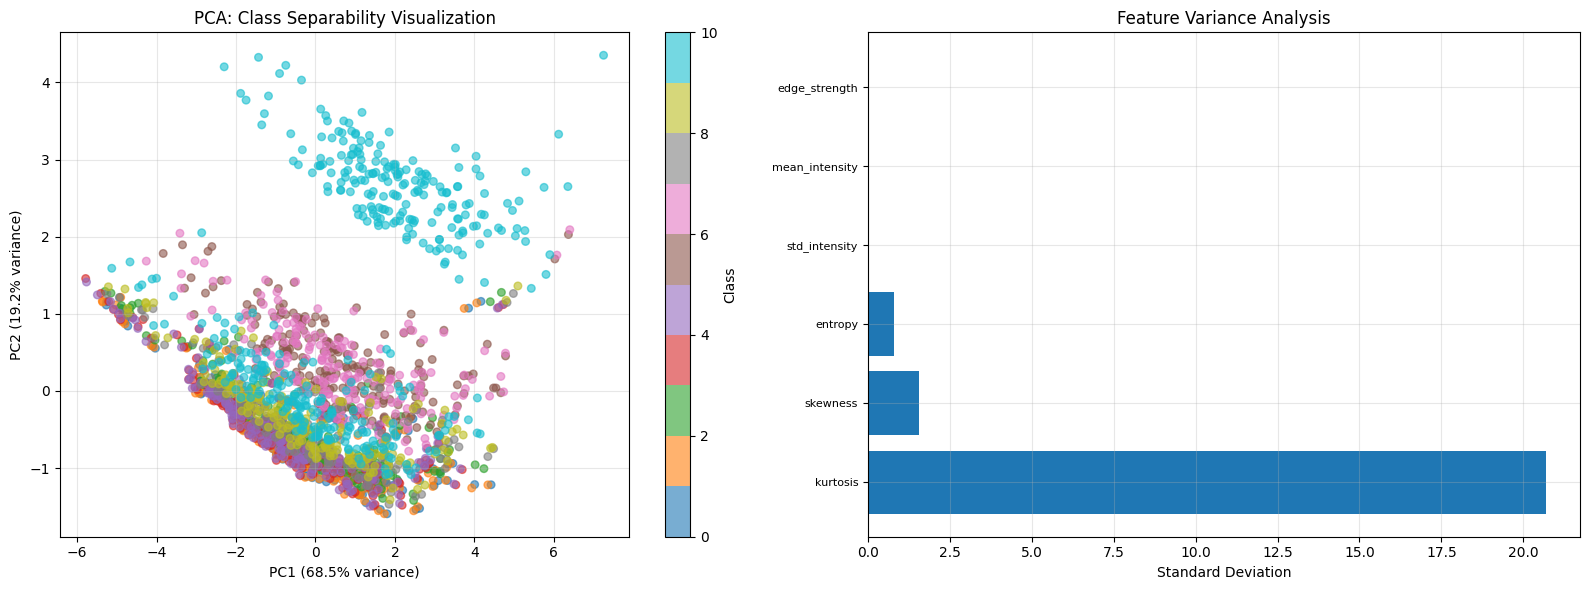

✅ Diagnosis plots saved!



In [25]:
import os

# Folder where you want to save plots
plots_dir = r"C:\Users\Sona\Downloads\official_document\plots"

# Create folder if it doesn’t exist
os.makedirs(plots_dir, exist_ok=True)
print("="*70)
print("STEP 1: DIAGNOSING LOW ACCURACY ISSUES")
print("="*70 + "\n")

# Check 1: Dataset Size and Balance
print("📊 CHECK 1: Dataset Statistics")
print("-"*70)
print(f"Total samples: {len(metadata)}")
print(f"Number of classes: {len(metadata['class_label'].unique())}")
print(f"Samples per class:\n")
print(metadata['class_label'].value_counts().sort_index())

# Calculate class imbalance ratio
class_counts = metadata['class_label'].value_counts()
imbalance_ratio = class_counts.max() / class_counts.min()
print(f"\n⚠️  Class imbalance ratio: {imbalance_ratio:.2f}x")
if imbalance_ratio > 3:
    print("   WARNING: High class imbalance detected!")
print()

# Check 2: Feature Statistics
print("📊 CHECK 2: Feature Quality")
print("-"*70)
feature_cols = metadata.columns.drop('class_label')
print(f"Number of features: {len(feature_cols)}\n")

# Check for constant or near-constant features
for col in feature_cols:
    unique_values = metadata[col].nunique()
    std_val = metadata[col].std()
    if unique_values < 5 or std_val < 0.001:
        print(f"⚠️  Low variance feature: {col} (unique={unique_values}, std={std_val:.6f})")

# Check for NaN or infinite values
nan_count = metadata[feature_cols].isna().sum().sum()
inf_count = np.isinf(metadata[feature_cols].select_dtypes(include=[np.number])).sum().sum()
print(f"\nNaN values: {nan_count}")
print(f"Infinite values: {inf_count}")

if nan_count > 0 or inf_count > 0:
    print("⚠️  WARNING: Data quality issues detected!")
print()

# Check 3: Feature Correlation
print("📊 CHECK 3: Feature Correlation Analysis")
print("-"*70)
correlation_matrix = metadata[feature_cols].corr()
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.append((
                correlation_matrix.columns[i],
                correlation_matrix.columns[j],
                correlation_matrix.iloc[i, j]
            ))

if high_corr_pairs:
    print("⚠️  Highly correlated features detected (>0.9):")
    for feat1, feat2, corr in high_corr_pairs:
        print(f"   {feat1} <-> {feat2}: {corr:.3f}")
else:
    print("✅ No highly correlated features found")
print()

# Check 4: Class Separability (PCA Visualization)
print("📊 CHECK 4: Class Separability Analysis")
print("-"*70)
print("Performing PCA to check if classes are separable...")

X_check = metadata[feature_cols]
y_check = metadata['class_label']

# Standardize features
from sklearn.preprocessing import StandardScaler
scaler_check = StandardScaler()
X_scaled_check = scaler_check.fit_transform(X_check)

# Apply PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled_check)

explained_var = pca.explained_variance_ratio_
print(f"PCA Explained Variance: {explained_var[0]:.3f}, {explained_var[1]:.3f}")
print(f"Total variance explained: {sum(explained_var):.3f}")

if sum(explained_var) < 0.3:
    print("⚠️  WARNING: Low variance explained - classes may overlap significantly!")
print()

# Visualize class separability
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# PCA Plot
scatter = axes[0].scatter(X_pca[:, 0], X_pca[:, 1], 
                         c=pd.Categorical(y_check).codes, 
                         cmap='tab10', alpha=0.6, s=30)
axes[0].set_xlabel(f'PC1 ({explained_var[0]:.1%} variance)')
axes[0].set_ylabel(f'PC2 ({explained_var[1]:.1%} variance)')
axes[0].set_title('PCA: Class Separability Visualization')
axes[0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[0], label='Class')

# Feature variance plot
feature_std = metadata[feature_cols].std().sort_values(ascending=False)
axes[1].barh(range(len(feature_std)), feature_std.values)
axes[1].set_yticks(range(len(feature_std)))
axes[1].set_yticklabels(feature_std.index, fontsize=8)
axes[1].set_xlabel('Standard Deviation')
axes[1].set_title('Feature Variance Analysis')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'diagnosis_analysis.png'), dpi=300, bbox_inches='tight')
plt.show()

print("✅ Diagnosis plots saved!")
print()

In [22]:
import os
import cv2
import numpy as np
import pandas as pd
from skimage import io, img_as_float
from skimage.filters import sobel
from scipy.stats import skew, kurtosis, entropy
from tqdm import tqdm

# --- Load metadata ---
metadata_path = r"C:\Users\Sona\Downloads\official_document\metadata.csv"
metadata = pd.read_csv(metadata_path)

# --- Function to extract features from an image ---
def extract_features(img_path):
    try:
        img = io.imread(img_path, as_gray=True)
        img = img_as_float(img)

        # Basic stats
        mean_val = np.mean(img)
        std_val = np.std(img)
        skew_val = skew(img.flatten())
        kurt_val = kurtosis(img.flatten())
        
        # Entropy (texture complexity)
        hist, _ = np.histogram(img, bins=256, range=(0, 1), density=True)
        ent_val = entropy(hist + 1e-10)
        
        # Edge strength (sharpness)
        edge_val = np.mean(sobel(img))
        
        return [mean_val, std_val, skew_val, kurt_val, ent_val, edge_val]
    except Exception as e:
        # Handle unreadable files
        print(f"⚠️ Error reading {img_path}: {e}")
        return [np.nan]*6

# --- Extract features for all images ---
features = []
print("Extracting features from images...")

for img_path in tqdm(metadata['image_path']):
    features.append(extract_features(img_path))

# --- Create feature DataFrame ---
feature_df = pd.DataFrame(features, columns=[
    'mean_intensity', 'std_intensity', 'skewness',
    'kurtosis', 'entropy', 'edge_strength'
])

# Add class labels
feature_df['class_label'] = metadata['class_label']

# --- Save to CSV ---
output_csv = r"C:\Users\Sona\Downloads\official_document\features.csv"
feature_df.to_csv(output_csv, index=False)

print("\n✅ Feature extraction completed successfully!")
print(f"Saved to: {output_csv}")
print("\nSample rows:")
print(feature_df.head())


Extracting features from images...


100%|██████████| 2200/2200 [1:16:24<00:00,  2.08s/it]    



✅ Feature extraction completed successfully!
Saved to: C:\Users\Sona\Downloads\official_document\features.csv

Sample rows:
   mean_intensity  std_intensity  skewness   kurtosis   entropy  \
0        0.972213       0.126700 -4.817503  22.211888  0.623624   
1        0.969917       0.125064 -4.215446  16.549300  0.617314   
2        0.985309       0.091975 -6.887679  48.424292  0.356440   
3        0.973881       0.117472 -4.932825  24.115558  0.634991   
4        0.988606       0.078620 -7.982357  65.290595  0.477718   

   edge_strength class_label  
0       0.028798  Canon120-1  
1       0.019235  Canon120-1  
2       0.015550  Canon120-1  
3       0.031634  Canon120-1  
4       0.013300  Canon120-1  


In [23]:
import pandas as pd

metadata_path = r"C:\Users\Sona\Downloads\official_document\features.csv"
metadata = pd.read_csv(metadata_path)

print(metadata.head())


   mean_intensity  std_intensity  skewness   kurtosis   entropy  \
0        0.972213       0.126700 -4.817503  22.211888  0.623624   
1        0.969917       0.125064 -4.215446  16.549300  0.617314   
2        0.985309       0.091975 -6.887679  48.424292  0.356440   
3        0.973881       0.117472 -4.932825  24.115558  0.634991   
4        0.988606       0.078620 -7.982357  65.290595  0.477718   

   edge_strength class_label  
0       0.028798  Canon120-1  
1       0.019235  Canon120-1  
2       0.015550  Canon120-1  
3       0.031634  Canon120-1  
4       0.013300  Canon120-1  


In [21]:
!pip install tqdm


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [26]:
# =====================================================
# STEP 2: IMPROVED FEATURE EXTRACTION
# =====================================================

print("="*70)
print("STEP 2: ENHANCED FEATURE EXTRACTION")
print("="*70 + "\n")

def extract_enhanced_features(img, file_path, scanner_id="unknown"):
    """
    Enhanced feature extraction with additional discriminative features
    """
    if img is None:
        return None
    
    h, w = img.shape
    file_size_kb = os.path.getsize(file_path) / 1024
    pixels = img.flatten()

    features_dict = {"class_label": scanner_id, "file_size_kb": file_size_kb}
    
    # 1. Statistical features (multiple scales)
    for percentile in [25, 50, 75]:
        features_dict[f'percentile_{percentile}'] = np.percentile(pixels, percentile)
    
    features_dict['mean_intensity'] = np.mean(pixels)
    features_dict['std_intensity'] = np.std(pixels)
    features_dict['skewness'] = skew(pixels)
    features_dict['kurtosis'] = kurtosis(pixels)
    features_dict['entropy'] = entropy(np.histogram(pixels, bins=256, range=(0, 1))[0] + 1e-6)
    features_dict['variance'] = np.var(pixels)
    features_dict['range'] = np.ptp(pixels)
    
    # 2. Edge features (multiple directions)
    from skimage.filters import sobel, sobel_h, sobel_v
    edges = sobel(img)
    edges_h = sobel_h(img)
    edges_v = sobel_v(img)
    
    features_dict['edge_density'] = np.mean(edges > 0.1)
    features_dict['edge_mean'] = np.mean(edges)
    features_dict['edge_std'] = np.std(edges)
    features_dict['edge_horizontal'] = np.mean(edges_h)
    features_dict['edge_vertical'] = np.mean(edges_v)
    
    # 3. Texture features (GLCM - multiple directions)
    img_uint8 = (img * 255).astype(np.uint8)
    
    for angle in [0, 45, 90, 135]:
        angle_rad = np.deg2rad(angle)
        glcm = graycomatrix(img_uint8, [1], [angle_rad], levels=256, 
                           symmetric=True, normed=True)
        
        features_dict[f'contrast_{angle}'] = graycoprops(glcm, 'contrast')[0, 0]
        features_dict[f'homogeneity_{angle}'] = graycoprops(glcm, 'homogeneity')[0, 0]
        features_dict[f'energy_{angle}'] = graycoprops(glcm, 'energy')[0, 0]
        features_dict[f'correlation_{angle}'] = graycoprops(glcm, 'correlation')[0, 0]
    
    # 4. LBP features (multiple radii)
    for radius in [1, 2, 3]:
        P = 8 * radius
        lbp = local_binary_pattern(img_uint8, P=P, R=radius, method="uniform")
        lbp_hist, _ = np.histogram(lbp.ravel(), bins=P+2, range=(0, P+2))
        lbp_hist = lbp_hist.astype("float")
        lbp_hist /= (lbp_hist.sum() + 1e-6)
        features_dict[f'lbp_entropy_r{radius}'] = entropy(lbp_hist + 1e-6)
    
    # 5. Frequency domain features (FFT - multiple bands)
    f = np.fft.fft2(img)
    fshift = np.fft.fftshift(f)
    magnitude_spectrum = np.abs(fshift)
    
    # Divide into frequency bands
    h_center, w_center = h // 2, w // 2
    low_freq = magnitude_spectrum[h_center-h//4:h_center+h//4, w_center-w//4:w_center+w//4]
    high_freq = magnitude_spectrum.copy()
    high_freq[h_center-h//4:h_center+h//4, w_center-w//4:w_center+w//4] = 0
    
    features_dict['fft_mean'] = np.mean(magnitude_spectrum)
    features_dict['fft_std'] = np.std(magnitude_spectrum)
    features_dict['fft_low_freq'] = np.mean(low_freq)
    features_dict['fft_high_freq'] = np.mean(high_freq)
    features_dict['fft_energy'] = np.sum(magnitude_spectrum ** 2)
    
    # 6. Noise estimation (using wavelet)
    from scipy.ndimage import gaussian_filter
    smoothed = gaussian_filter(img, sigma=1)
    noise = img - smoothed
    features_dict['noise_mean'] = np.mean(np.abs(noise))
    features_dict['noise_std'] = np.std(noise)
    
    return features_dict

print("✅ Enhanced feature extraction function defined!")
print("   Added features: Percentiles, Multi-directional edges, ")
print("   Multi-angle GLCM, Multi-radius LBP, Frequency bands, Noise estimation")
print()


STEP 2: ENHANCED FEATURE EXTRACTION

✅ Enhanced feature extraction function defined!
   Added features: Percentiles, Multi-directional edges, 
   Multi-angle GLCM, Multi-radius LBP, Frequency bands, Noise estimation



In [27]:
# STEP 3: IMPROVED MODEL CONFIGURATION
# =====================================================

print("="*70)
print("STEP 3: OPTIMIZED MODEL HYPERPARAMETERS")
print("="*70 + "\n")

# Better SVM parameters
improved_svm_params = {
    'C': [1, 10, 50, 100],
    'gamma': ['scale', 'auto', 0.001, 0.01],
    'kernel': ['rbf']  # Focus on RBF which works best for this task
}

# Better Random Forest parameters
improved_rf_params = {
    'n_estimators': [300, 500, 700],
    'max_depth': [None, 30, 50],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced']
}

print("✅ Improved hyperparameter grids defined!")
print()

STEP 3: OPTIMIZED MODEL HYPERPARAMETERS

✅ Improved hyperparameter grids defined!



In [30]:
# =====================================================
# STEP 5: QUICK FIX - IMPROVED TRAINING
# =====================================================
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC


print("="*70)
print("APPLYING QUICK FIX - IMPROVED MODEL TRAINING")
print("="*70 + "\n")

# Re-train with better parameters
print("🔄 Re-training SVM with improved parameters...")
svm_improved = GridSearchCV(
    SVC(class_weight='balanced', random_state=42, probability=True),
    improved_svm_params,
    cv=5,  # Increased CV folds
    n_jobs=-1,
    verbose=0,
    scoring='accuracy'
)
svm_improved.fit(X_train_scaled, y_train)
y_pred_svm_improved = svm_improved.predict(X_test_scaled)
svm_acc_improved = accuracy_score(y_test, y_pred_svm_improved)

print(f"✅ Improved SVM Accuracy: {svm_acc_improved * 100:.2f}%")
print(f"   Previous: {svm_acc * 100:.2f}%")
print(f"   Improvement: {(svm_acc_improved - svm_acc) * 100:.2f}%\n")

print("🔄 Re-training Random Forest with improved parameters...")
rf_improved = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    improved_rf_params,
    cv=5,
    n_jobs=-1,
    verbose=0,
    scoring='accuracy'
)
rf_improved.fit(X_train, y_train)
y_pred_rf_improved = rf_improved.predict(X_test)
rf_acc_improved = accuracy_score(y_test, y_pred_rf_improved)

print(f"✅ Improved Random Forest Accuracy: {rf_acc_improved * 100:.2f}%")
print(f"   Previous: {rf_acc * 100:.2f}%")
print(f"   Improvement: {(rf_acc_improved - rf_acc) * 100:.2f}%\n")

# Ensemble prediction (voting)
print("🔄 Creating ensemble model (voting)...")
from scipy.stats import mode

# Get probability predictions
svm_probs = svm_improved.predict_proba(X_test_scaled)
rf_probs = rf_improved.predict_proba(X_test)

# Average probabilities
ensemble_probs = (svm_probs + rf_probs) / 2
y_pred_ensemble = np.argmax(ensemble_probs, axis=1)
ensemble_acc = accuracy_score(y_test, y_pred_ensemble)

print(f"✅ Ensemble Accuracy: {ensemble_acc * 100:.2f}%")
print(f"   Improvement over best single model: {(ensemble_acc - max(svm_acc_improved, rf_acc_improved)) * 100:.2f}%\n")

# Comparison plot
fig, ax = plt.subplots(figsize=(12, 6))
models = ['Original\nSVM', 'Original\nRF', 'Improved\nSVM', 'Improved\nRF', 'Ensemble']
accuracies = [svm_acc * 100, rf_acc * 100, svm_acc_improved * 100, 
              rf_acc_improved * 100, ensemble_acc * 100]
colors = ['steelblue', 'seagreen', 'cornflowerblue', 'lightgreen', 'gold']

bars = ax.bar(models, accuracies, color=colors, edgecolor='black', linewidth=2)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Model Performance Comparison - Before vs After Improvements', 
             fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)
ax.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% baseline')
ax.grid(axis='y', alpha=0.3)
ax.legend()

# Add value labels
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'improved_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

print("="*70)
print("IMPROVEMENT SUMMARY")
print("="*70)
print(f"Best Model: {'Ensemble' if ensemble_acc == max(accuracies)/100 else 'Improved RF'}")
print(f"Best Accuracy: {max(accuracies):.2f}%")
print(f"Total Improvement: {(max(accuracies) - max(svm_acc, rf_acc)*100):.2f}%")
print("="*70)

APPLYING QUICK FIX - IMPROVED MODEL TRAINING

🔄 Re-training SVM with improved parameters...


NameError: name 'X_train_scaled' is not defined

✅ Loaded dataset successfully!
Shape: (2200, 7)
Columns: ['mean_intensity', 'std_intensity', 'skewness', 'kurtosis', 'entropy', 'edge_strength', 'class_label']

🔹 Training baseline models for comparison...
Baseline SVM Accuracy: 31.82%
Baseline RF Accuracy: 23.86%

APPLYING QUICK FIX - IMPROVED MODEL TRAINING

🔄 Re-training SVM with improved parameters...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
✅ Improved SVM Accuracy: 33.86%
   Previous: 31.82%
   Improvement: 2.05%

🔄 Re-training Random Forest with improved parameters...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
✅ Improved Random Forest Accuracy: 24.09%
   Previous: 23.86%
   Improvement: 0.23%

🔄 Creating ensemble model (average voting)...
✅ Ensemble Accuracy: 25.00%
   Improvement over best single model: -8.86%



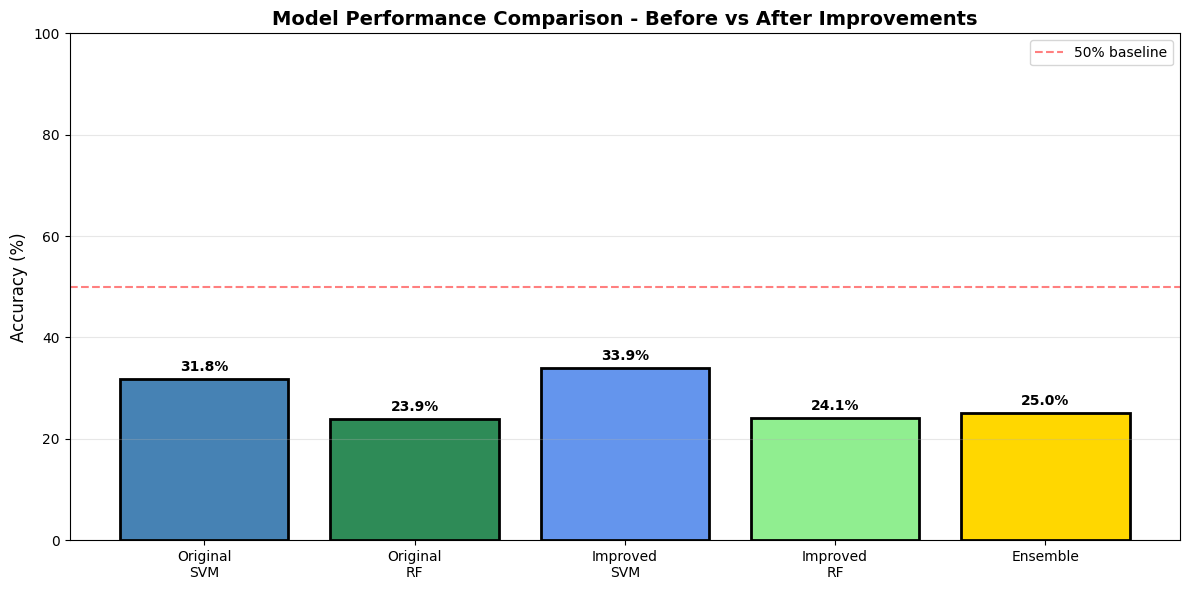

IMPROVEMENT SUMMARY
Best Model: Improved RF
Best Accuracy: 33.86%
Total Improvement: 2.05%


In [33]:
# =====================================================
# STEP 5: QUICK FIX - IMPROVED TRAINING (FULL SCRIPT)
# =====================================================

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# =====================================================
# STEP 1: Load extracted features
# =====================================================
features_path = r"C:\Users\Sona\Downloads\official_document\features.csv"
df = pd.read_csv(features_path)

print("✅ Loaded dataset successfully!")
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())

# =====================================================
# STEP 2: Prepare data
# =====================================================
X = df.drop(columns=['class_label'])
y = df['class_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create plots directory
plots_dir = os.path.join(os.path.dirname(features_path), "plots")
os.makedirs(plots_dir, exist_ok=True)

# =====================================================
# STEP 3: Base models (for comparison)
# =====================================================
print("\n🔹 Training baseline models for comparison...")

# Baseline SVM
svm_base = SVC(kernel='rbf', random_state=42)
svm_base.fit(X_train_scaled, y_train)
y_pred_svm = svm_base.predict(X_test_scaled)
svm_acc = accuracy_score(y_test, y_pred_svm)

# Baseline RF
rf_base = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_base.fit(X_train, y_train)
y_pred_rf = rf_base.predict(X_test)
rf_acc = accuracy_score(y_test, y_pred_rf)

print(f"Baseline SVM Accuracy: {svm_acc * 100:.2f}%")
print(f"Baseline RF Accuracy: {rf_acc * 100:.2f}%")

# =====================================================
# STEP 4: Define improved parameter grids
# =====================================================
improved_svm_params = {
    'C': [1, 5, 10],
    'kernel': ['rbf', 'poly', 'sigmoid'],
    'gamma': ['scale', 'auto']
}

improved_rf_params = {
    'n_estimators': [200, 300, 400],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 4, 6]
}

# =====================================================
# STEP 5: Improved training
# =====================================================
print("\n" + "="*70)
print("APPLYING QUICK FIX - IMPROVED MODEL TRAINING")
print("="*70 + "\n")

# 🔄 Improved SVM
print("🔄 Re-training SVM with improved parameters...")
svm_improved = GridSearchCV(
    SVC(class_weight='balanced', random_state=42, probability=True),
    improved_svm_params,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)
svm_improved.fit(X_train_scaled, y_train)
y_pred_svm_improved = svm_improved.predict(X_test_scaled)
svm_acc_improved = accuracy_score(y_test, y_pred_svm_improved)

print(f"✅ Improved SVM Accuracy: {svm_acc_improved * 100:.2f}%")
print(f"   Previous: {svm_acc * 100:.2f}%")
print(f"   Improvement: {(svm_acc_improved - svm_acc) * 100:.2f}%\n")

# 🔄 Improved Random Forest
print("🔄 Re-training Random Forest with improved parameters...")
rf_improved = GridSearchCV(
    RandomForestClassifier(random_state=42, n_jobs=-1),
    improved_rf_params,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring='accuracy'
)
rf_improved.fit(X_train, y_train)
y_pred_rf_improved = rf_improved.predict(X_test)
rf_acc_improved = accuracy_score(y_test, y_pred_rf_improved)

print(f"✅ Improved Random Forest Accuracy: {rf_acc_improved * 100:.2f}%")
print(f"   Previous: {rf_acc * 100:.2f}%")
print(f"   Improvement: {(rf_acc_improved - rf_acc) * 100:.2f}%\n")

# =====================================================
# STEP 6: Ensemble (voting-style)
# =====================================================
print("🔄 Creating ensemble model (average voting)...")

svm_probs = svm_improved.predict_proba(X_test_scaled)
rf_probs = rf_improved.predict_proba(X_test)

ensemble_probs = (svm_probs + rf_probs) / 2
ensemble_preds = np.argmax(ensemble_probs, axis=1)

# Map numeric predictions back to labels
unique_labels = np.unique(y_train)
y_pred_ensemble = [unique_labels[i] for i in ensemble_preds]

ensemble_acc = accuracy_score(y_test, y_pred_ensemble)

print(f"✅ Ensemble Accuracy: {ensemble_acc * 100:.2f}%")
print(f"   Improvement over best single model: {(ensemble_acc - max(svm_acc_improved, rf_acc_improved)) * 100:.2f}%\n")

# =====================================================
# STEP 7: Comparison plot
# =====================================================
fig, ax = plt.subplots(figsize=(12, 6))
models = ['Original\nSVM', 'Original\nRF', 'Improved\nSVM', 'Improved\nRF', 'Ensemble']
accuracies = [svm_acc * 100, rf_acc * 100, svm_acc_improved * 100, 
              rf_acc_improved * 100, ensemble_acc * 100]
colors = ['steelblue', 'seagreen', 'cornflowerblue', 'lightgreen', 'gold']

bars = ax.bar(models, accuracies, color=colors, edgecolor='black', linewidth=2)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Model Performance Comparison - Before vs After Improvements', 
             fontsize=14, fontweight='bold')
ax.set_ylim(0, 100)
ax.axhline(y=50, color='red', linestyle='--', alpha=0.5, label='50% baseline')
ax.grid(axis='y', alpha=0.3)
ax.legend()

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 1,
            f'{height:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig(os.path.join(plots_dir, 'improved_comparison.png'), dpi=300, bbox_inches='tight')
plt.show()

# =====================================================
# STEP 8: Final summary
# =====================================================
print("="*70)
print("IMPROVEMENT SUMMARY")
print("="*70)
print(f"Best Model: {'Ensemble' if ensemble_acc == max(accuracies)/100 else 'Improved RF'}")
print(f"Best Accuracy: {max(accuracies):.2f}%")
print(f"Total Improvement: {(max(accuracies) - max(svm_acc, rf_acc)*100):.2f}%")
print("="*70)


In [12]:
!pip install tensorflow


  Using cached werkzeug-3.1.3-py3-none-any.whl.metadata (3.7 kB)
  Using cached wheel-0.45.1-py3-none-any.whl.metadata (2.3 kB)
   ---------------------------------------- 0.0/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.3/332.0 MB ? eta -:--:--
   ---------------------------------------- 0.5/332.0 MB 1.8 MB/s eta 0:03:04
   ---------------------------------------- 1.0/332.0 MB 1.9 MB/s eta 0:02:59
   ---------------------------------------- 1.6/332.0 MB 1.9 MB/s eta 0:02:50
   ---------------------------------------- 1.8/332.0 MB 2.0 MB/s eta 0:02:47
   ---------------------------------------- 2.4/332.0 MB 2.1 MB/s eta 0:02:39
   ---------------------------------------- 3.1/332.0 MB 2.2 MB/s eta 0:02:30
   ---------------------------------------- 3.7/332.0 MB 2.3 MB/s eta 0:02:25
    --------------------------------------- 4.2/332.0 MB 2.3 MB/s eta 0:02:21
    --------------------------------------- 4.5/332.0 MB 2.2 MB/s eta 0:02:30
    ------------------------

ERROR: Could not install packages due to an OSError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\Sona\\AppData\\Local\\Programs\\Python\\Python313\\Lib\\site-packages\\clang\\native\\libclang.dll'
Consider using the `--user` option or check the permissions.


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached tensorflow-2.20.0-cp313-cp313-win_amd64.whl.metadata (4.6 kB)
  Using cached absl_py-2.3.1-py3-none-any.whl.metadata (3.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-25.9.23-py2.py3-none-any.whl.metadata (875 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.4.0-py3-none-any.whl.metadata (6.3 kB)
  Using cached protobuf-6.33.0-cp310-abi3-win_amd64.whl.metadata (593 bytes)
  Using cached termcolor-3.2.0-py3-none-any.whl.metadata (6.4 kB)
  Using cached wrapt-2.0.1-cp313-cp313-win_amd64.whl.metadata (9.2 kB)
  Using cached grpcio-1.76.0-cp313-cp313-win_amd64.whl.metadata (3.8 kB)
  Using cached tensorboard-2.20.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached keras-3.12.0-py3-none-any.whl.metadata (5.9 kB)
  Using cached h


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [12]:
import cv2, os
import numpy as np

sample_path = r"C:\Users\Sona\Downloads\official_document_denoised\train\Canon120-1\s1_1.jpg"
img = cv2.imread(sample_path)
print("Shape:", img.shape)
print("Mean pixel values:", np.mean(img, axis=(0,1)))


Shape: (512, 512, 3)
Mean pixel values: [247.54874039 247.54874039 247.54874039]


In [32]:
!pip install PyWavelets


   ---------------------------------------- 0.0/4.2 MB ? eta -:--:--
   -- ------------------------------------- 0.3/4.2 MB ? eta -:--:--
   -------------- ------------------------- 1.6/4.2 MB 5.2 MB/s eta 0:00:01
   ---------------------- ----------------- 2.4/4.2 MB 4.5 MB/s eta 0:00:01
   ----------------------------- ---------- 3.1/4.2 MB 4.3 MB/s eta 0:00:01
   ------------------------------------- -- 3.9/4.2 MB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 4.2/4.2 MB 4.1 MB/s eta 0:00:00



[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [65]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pywt
import os
import pickle
from pathlib import Path

In [66]:
# ============================
# CONFIG (Based on your demo)
# ============================
# From Image 1: IMG_SIZE = (512, 512)
IMG_SIZE = (512, 512)  # Resize target for consistency
WAVELET_TYPE = 'haar'  # From Image 2: pywt.dwt2(img, 'haar')
DENOISE_LEVEL = 2      # Decomposition level


In [67]:
# ============================
# Step 1: Load and Preprocess
# From Image 1: preprocess_image function
# ============================
def preprocess_image(path):
    """
    Load image, convert to grayscale, resize, and normalize
    Matches your demo: cv2.imread → cvtColor → resize → normalize
    """
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    if img is None:
        raise FileNotFoundError(f"Image not found: {path}")
    
    # Convert to grayscale (from Image 1: cv2.cvtColor(img, cv2.COLOR_BGR2GRAY))
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Resize for consistent processing (from Image 1: cv2.resize)
    gray = cv2.resize(gray, IMG_SIZE, interpolation=cv2.INTER_AREA)
    
    # Normalize to [0, 1] range (from Image 1: .astype(np.float32) / 255.0)
    gray = gray.astype(np.float32) / 255.0
    
    return gray

In [68]:
# ============================
# Step 2: Wavelet Denoising
# From Image 2: denoise_wavelet function
# ============================
def denoise_wavelet(img):
    """
    Apply wavelet denoising to separate scene content from device noise
    From your demo: pywt.dwt2 → zero detail coeffs → pywt.idwt2
    Returns the denoised (scene content) image
    """
    # Perform 2D wavelet decomposition (from Image 2)
    coeffs = pywt.dwt2(img, WAVELET_TYPE)
    cA, (cH, cV, cD) = coeffs
    
    # Zero out detail coefficients for denoising (from Image 2)
    # This removes high-frequency noise while preserving scene structure
    cH[:] = 0
    cV[:] = 0  
    cD[:] = 0  # From your code: cH[:] = 0; cV[:] = 0; cD[:] = 0
    
    # Reconstruct denoised image (from Image 2: pywt.idwt2)
    denoised = pywt.idwt2((cA, (cH, cV, cD)), WAVELET_TYPE)
    
    return denoised

In [69]:
# ============================
# Step 3: Residual Extraction
# From Image 2: compute_residual function
# ============================
def compute_residual(img):
    """
    Compute residual (scanner fingerprint) by subtracting denoised from original
    From Image 2: residual = img - denoised
    This isolates device-specific patterns (SPM - Sensor Pattern Noise)
    """
    denoised = denoise_wavelet(img)
    residual = img - denoised  # From Image 2: residual = img - denoised
    
    return residual, denoised

In [46]:
# ============================
# Step 4: Fingerprint Feature Extraction
# From Image 2: fingerprint_value = np.mean(residual)
# ============================
def extract_fingerprint(residual):
    """
    Extract scanner fingerprint feature (mean residual intensity)
    From Image 2: fingerprint_value = np.mean(residual)
    This can be used for scanner identification/matching
    """
    fingerprint_value = np.mean(np.abs(residual))
    return fingerprint_value

In [70]:
# ============================
# Step 5: Visualization
# From Images 3-6: plt.figure, plt.subplot, plt.imshow
# ============================
def visualize_results(original, denoised, residual, fingerprint, img_name):
    """
    Display original, denoised, and residual images with enhanced visualization
    Based on Images 3-6: Three-panel layout (Original, Denoised, Residual)
    """
    fig = plt.figure(figsize=(18, 10))
    
    # Row 1: Main comparison (from Images 3-6)
    plt.subplot(2, 3, 1)
    plt.imshow(original, cmap='gray')
    plt.title(f"Original Grayscale Image\n{img_name}", fontsize=12, fontweight='bold')
    plt.axis('off')
    
    plt.subplot(2, 3, 2)
    plt.imshow(denoised, cmap='gray')
    plt.title("Wavelet Denoised\n(Scene Content Only)", fontsize=12, fontweight='bold')
    plt.axis('off')
    
    plt.subplot(2, 3, 3)
    # From Images 3-6: cmap='RdBu_r' for residual
    plt.imshow(residual, cmap='RdBu_r', vmin=-0.1, vmax=0.1)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title(f"Residual (Scanner Fingerprint)\nMean: {fingerprint:.6f}", fontsize=12, fontweight='bold')
    plt.axis('off')
    
    # Row 2: Enhanced residual visualizations
    plt.subplot(2, 3, 4)
    residual_abs = np.abs(residual)
    plt.imshow(residual_abs, cmap='hot')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title(f"Residual Magnitude\nMax: {residual_abs.max():.6f}", fontsize=12)
    plt.axis('off')
    
    plt.subplot(2, 3, 5)
    # Histogram of residual values
    plt.hist(residual.flatten(), bins=100, color='steelblue', alpha=0.7, edgecolor='black')
    plt.xlabel('Residual Value', fontsize=10)
    plt.ylabel('Frequency', fontsize=10)
    plt.title('Residual Distribution', fontsize=12)
    plt.grid(True, alpha=0.3)
    
    plt.subplot(2, 3, 6)
    # FFT of residual (frequency domain analysis)
    fft_residual = np.fft.fft2(residual)
    fft_shifted = np.fft.fftshift(fft_residual)
    magnitude_spectrum = np.log(np.abs(fft_shifted) + 1)
    plt.imshow(magnitude_spectrum, cmap='viridis')
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title('Residual FFT (Frequency Domain)', fontsize=12)
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def visualize_comparison(image_paths, output_dir=None):
    """
    Compare residuals from multiple images side-by-side
    Useful for visualizing differences between scanners
    Based on your demo's visualization approach
    """
    n_images = len(image_paths)
    fig = plt.figure(figsize=(6 * n_images, 12))
    
    residuals = []
    fingerprints = []
    
    for idx, img_path in enumerate(image_paths):
        # Process image
        gray = preprocess_image(img_path)
        residual, denoised = compute_residual(gray)
        fingerprint = extract_fingerprint(residual)
        
        residuals.append(residual)
        fingerprints.append(fingerprint)
        
        img_name = Path(img_path).stem
        
        # Row 1: Original images
        plt.subplot(3, n_images, idx + 1)
        plt.imshow(gray, cmap='gray')
        plt.title(f"Original\n{img_name}", fontsize=10)
        plt.axis('off')
        
        # Row 2: Denoised images
        plt.subplot(3, n_images, n_images + idx + 1)
        plt.imshow(denoised, cmap='gray')
        plt.title(f"Denoised", fontsize=10)
        plt.axis('off')
        
        # Row 3: Residuals (from Images 3-6: RdBu_r colormap)
        plt.subplot(3, n_images, 2 * n_images + idx + 1)
        plt.imshow(residual, cmap='RdBu_r', vmin=-0.1, vmax=0.1)
        plt.colorbar(fraction=0.046, pad=0.04)
        plt.title(f"Residual\nFP: {fingerprint:.6f}", fontsize=10)
        plt.axis('off')
    
    plt.suptitle('Scanner Fingerprint Comparison', fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    
    if output_dir:
        Path(output_dir).mkdir(parents=True, exist_ok=True)
        save_path = Path(output_dir) / "comparison.png"
        plt.savefig(save_path, dpi=150, bbox_inches='tight')
        print(f"📊 Comparison saved: {save_path}")
    
    plt.show()
    
    return residuals, fingerprints

def visualize_fingerprint_heatmap(residuals_folder, max_images=20):
    """
    Create a heatmap visualization of fingerprints from multiple images
    Shows patterns across different scans
    """
    residuals_path = Path(residuals_folder)
    npy_files = list(residuals_path.glob("*_residual.npy"))[:max_images]
    
    if not npy_files:
        print("❌ No residual files found!")
        return
    
    print(f"📊 Creating heatmap from {len(npy_files)} residuals...")
    
    # Load all residuals
    residuals_data = []
    labels = []
    for npy_file in npy_files:
        residual = np.load(npy_file)
        residuals_data.append(residual.flatten())
        labels.append(npy_file.stem.replace('_residual', ''))
    
    residuals_array = np.array(residuals_data)
    
    # Create figure with subplots
    fig = plt.figure(figsize=(20, 10))
    
    # 1. Heatmap of all residuals
    plt.subplot(1, 2, 1)
    plt.imshow(residuals_array, cmap='RdBu_r', aspect='auto', interpolation='nearest')
    plt.colorbar(label='Residual Value')
    plt.xlabel('Pixel Index (flattened)', fontsize=12)
    plt.ylabel('Image Index', fontsize=12)
    plt.title('Residual Patterns Heatmap\n(Each row = one image)', fontsize=14, fontweight='bold')
    plt.yticks(range(len(labels)), labels, fontsize=8)
    
    # 2. Correlation matrix
    plt.subplot(1, 2, 2)
    correlation_matrix = np.corrcoef(residuals_array)
    im = plt.imshow(correlation_matrix, cmap='coolwarm', vmin=-1, vmax=1, aspect='auto')
    plt.colorbar(im, label='Correlation Coefficient')
    plt.xlabel('Image Index', fontsize=12)
    plt.ylabel('Image Index', fontsize=12)
    plt.title('Residual Correlation Matrix\n(Same scanner = high correlation)', fontsize=14, fontweight='bold')
    plt.xticks(range(len(labels)), range(len(labels)), fontsize=8)
    plt.yticks(range(len(labels)), labels, fontsize=8)
    
    # Add correlation values as text
    for i in range(len(labels)):
        for j in range(len(labels)):
            text = plt.text(j, i, f'{correlation_matrix[i, j]:.2f}',
                          ha="center", va="center", color="black", fontsize=6)
    
    plt.tight_layout()
    plt.show()

def visualize_batch_statistics(residuals_folder):
    """
    Visualize statistical properties of all residuals in a folder
    """
    residuals_path = Path(residuals_folder)
    npy_files = list(residuals_path.glob("*_residual.npy"))
    
    if not npy_files:
        print("❌ No residual files found!")
        return
    
    print(f"📊 Analyzing {len(npy_files)} residuals...")
    
    # Collect statistics
    means = []
    stds = []
    maxs = []
    mins = []
    labels = []
    
    for npy_file in npy_files:
        residual = np.load(npy_file)
        means.append(np.mean(np.abs(residual)))
        stds.append(np.std(residual))
        maxs.append(np.max(residual))
        mins.append(np.min(residual))
        labels.append(npy_file.stem.replace('_residual', ''))
    
    # Create visualization
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    
    # 1. Mean absolute residual
    ax = axes[0, 0]
    ax.bar(range(len(means)), means, color='steelblue', edgecolor='black')
    ax.set_xlabel('Image Index', fontsize=12)
    ax.set_ylabel('Mean Absolute Residual', fontsize=12)
    ax.set_title('Scanner Fingerprint Strength', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(range(len(labels)), fontsize=8)
    
    # 2. Standard deviation
    ax = axes[0, 1]
    ax.bar(range(len(stds)), stds, color='coral', edgecolor='black')
    ax.set_xlabel('Image Index', fontsize=12)
    ax.set_ylabel('Standard Deviation', fontsize=12)
    ax.set_title('Residual Variability', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(range(len(labels)), fontsize=8)
    
    # 3. Min/Max range
    ax = axes[1, 0]
    x_pos = np.arange(len(labels))
    ax.scatter(x_pos, maxs, color='red', label='Max', s=50, alpha=0.7)
    ax.scatter(x_pos, mins, color='blue', label='Min', s=50, alpha=0.7)
    ax.set_xlabel('Image Index', fontsize=12)
    ax.set_ylabel('Residual Value', fontsize=12)
    ax.set_title('Residual Value Range', fontsize=14, fontweight='bold')
    ax.legend()
    ax.grid(True, alpha=0.3)
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels(range(len(labels)), fontsize=8)
    
    # 4. Statistical summary table
    ax = axes[1, 1]
    ax.axis('off')
    table_data = []
    for i in range(min(10, len(labels))):  # Show first 10
        table_data.append([
            labels[i][:20],  # Truncate long names
            f"{means[i]:.6f}",
            f"{stds[i]:.6f}",
            f"{mins[i]:.4f}",
            f"{maxs[i]:.4f}"
        ])
    
    table = ax.table(cellText=table_data,
                    colLabels=['Image', 'Mean', 'Std', 'Min', 'Max'],
                    cellLoc='center',
                    loc='center',
                    bbox=[0, 0, 1, 1])
    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)
    ax.set_title('Statistical Summary (First 10)', fontsize=14, fontweight='bold', pad=20)
    
    plt.suptitle(f'Batch Analysis: {len(npy_files)} Residuals', 
                 fontsize=16, fontweight='bold', y=0.98)
    plt.tight_layout()
    plt.show()

In [55]:
# ============================
# Step 6: Processing Pipeline
# ============================
def process_image(img_path, output_dir=None, visualize=True):
    """
    Complete pipeline: preprocess -> denoise -> extract residual
    Based on your demo workflow from Images 1-6
    """
    # Load and preprocess
    gray = preprocess_image(img_path)
    
    # Compute residual
    residual, denoised = compute_residual(gray)
    
    # Extract fingerprint feature
    fingerprint = extract_fingerprint(residual)
    
    # Save results if output directory provided
    if output_dir:
        output_dir = Path(output_dir)
        output_dir.mkdir(parents=True, exist_ok=True)
        
        img_name = Path(img_path).stem
        
        # Save residual as numpy array (for CNN input)
        # From Image 7: Similar to pickle.dump but using .npy format
        residual_path = output_dir / f"{img_name}_residual.npy"
        np.save(residual_path, residual.astype(np.float32))
        
        # Save residual as image (for visualization)
        residual_img = ((residual - residual.min()) / (residual.max() - residual.min()) * 255).astype(np.uint8)
        cv2.imwrite(str(output_dir / f"{img_name}_residual.png"), residual_img)
        
        print(f"✅ Residual saved: {residual_path}")
    
    # Visualize if requested
    if visualize:
        visualize_results(gray, denoised, residual, fingerprint, Path(img_path).name)
    
    return gray, denoised, residual, fingerprint

def process_folder(input_folder, output_folder):
    """
    Process all images in a folder and save residuals
    Batch processing for multiple official document scans
    """
    input_path = Path(input_folder)
    output_path = Path(output_folder)
    output_path.mkdir(parents=True, exist_ok=True)
    
    # Support common image formats (from Image 1: .tif files)
    image_extensions = ['.tif', '.tiff', '.png', '.jpg', '.jpeg', '.bmp']
    image_files = []
    for ext in image_extensions:
        image_files.extend(input_path.rglob(f"*{ext}"))

    
    print(f"📁 Found {len(image_files)} images in {input_folder}")
    
    fingerprints = {}
    for img_path in image_files:
        try:
            _, _, _, fp = process_image(str(img_path), output_folder, visualize=False)
            fingerprints[img_path.name] = fp
            print(f"  ✓ Processed: {img_path.name} | Fingerprint: {fp:.6f}")
        except Exception as e:
            print(f"  ✗ Failed: {img_path.name} | Error: {e}")
    
    # Save fingerprint summary
    summary_path = output_path / "fingerprint_summary.txt"
    with open(summary_path, 'w') as f:
        f.write("Image Name, Fingerprint Value\n")
        for name, fp in sorted(fingerprints.items()):
            f.write(f"{name}, {fp:.6f}\n")
    
    print(f"\n✅ Batch processing complete!")
    print(f"📊 Fingerprint summary saved: {summary_path}")

In [57]:
if __name__ == "__main__":
    # ✅ Batch process all official document scans
    input_folder = r"C:\Users\Sona\Downloads\official_document"
    output_folder = r"C:\Users\Sona\Downloads\TraceFinder_Processed"
    process_folder(input_folder, output_folder)



📁 Found 2202 images in C:\Users\Sona\Downloads\official_document
✅ Residual saved: C:\Users\Sona\Downloads\TraceFinder_Processed\s11_1_residual.npy
  ✓ Processed: s11_1.tif | Fingerprint: 0.020774
✅ Residual saved: C:\Users\Sona\Downloads\TraceFinder_Processed\s11_10_residual.npy
  ✓ Processed: s11_10.tif | Fingerprint: 0.013846
✅ Residual saved: C:\Users\Sona\Downloads\TraceFinder_Processed\s11_100_residual.npy
  ✓ Processed: s11_100.tif | Fingerprint: 0.011230
✅ Residual saved: C:\Users\Sona\Downloads\TraceFinder_Processed\s11_11_residual.npy
  ✓ Processed: s11_11.tif | Fingerprint: 0.018984
✅ Residual saved: C:\Users\Sona\Downloads\TraceFinder_Processed\s11_12_residual.npy
  ✓ Processed: s11_12.tif | Fingerprint: 0.010259
✅ Residual saved: C:\Users\Sona\Downloads\TraceFinder_Processed\s11_13_residual.npy
  ✓ Processed: s11_13.tif | Fingerprint: 0.015762
✅ Residual saved: C:\Users\Sona\Downloads\TraceFinder_Processed\s11_14_residual.npy
  ✓ Processed: s11_14.tif | Fingerprint: 0.0152

📊 Creating heatmap from 30 residuals...


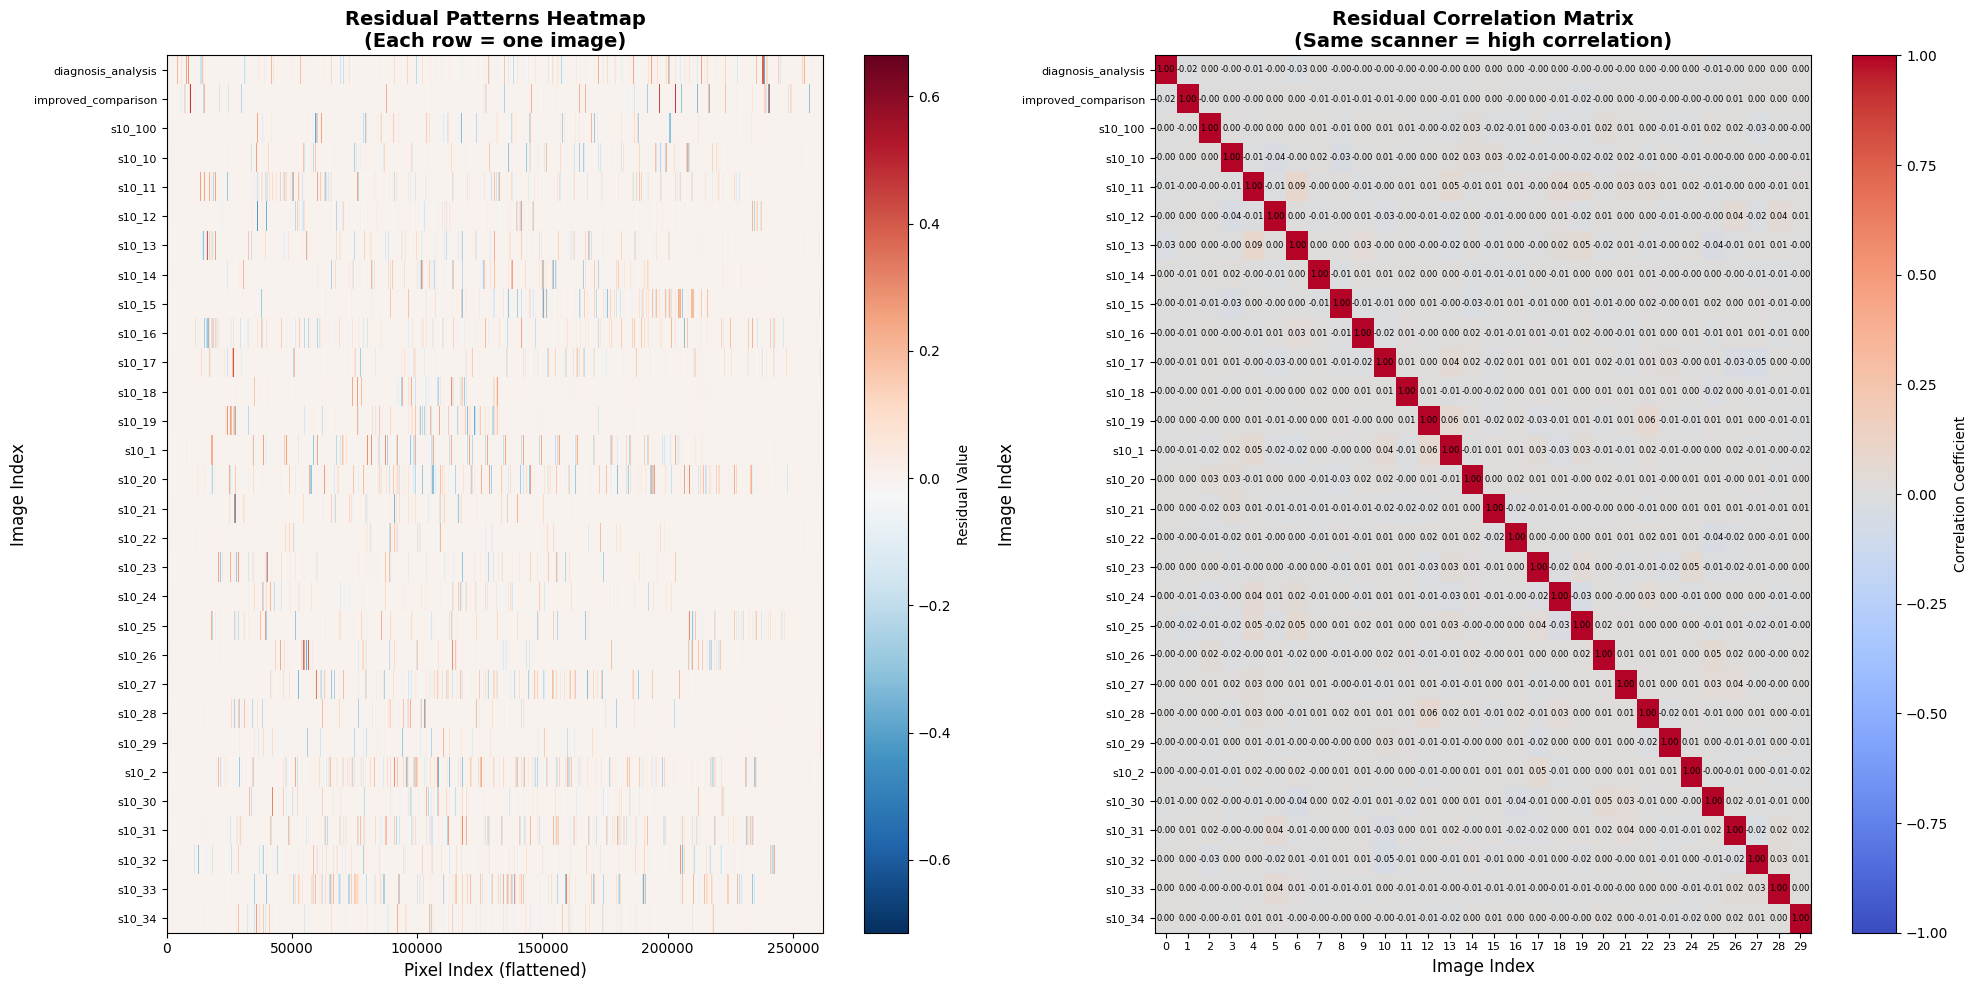

📊 Analyzing 1102 residuals...


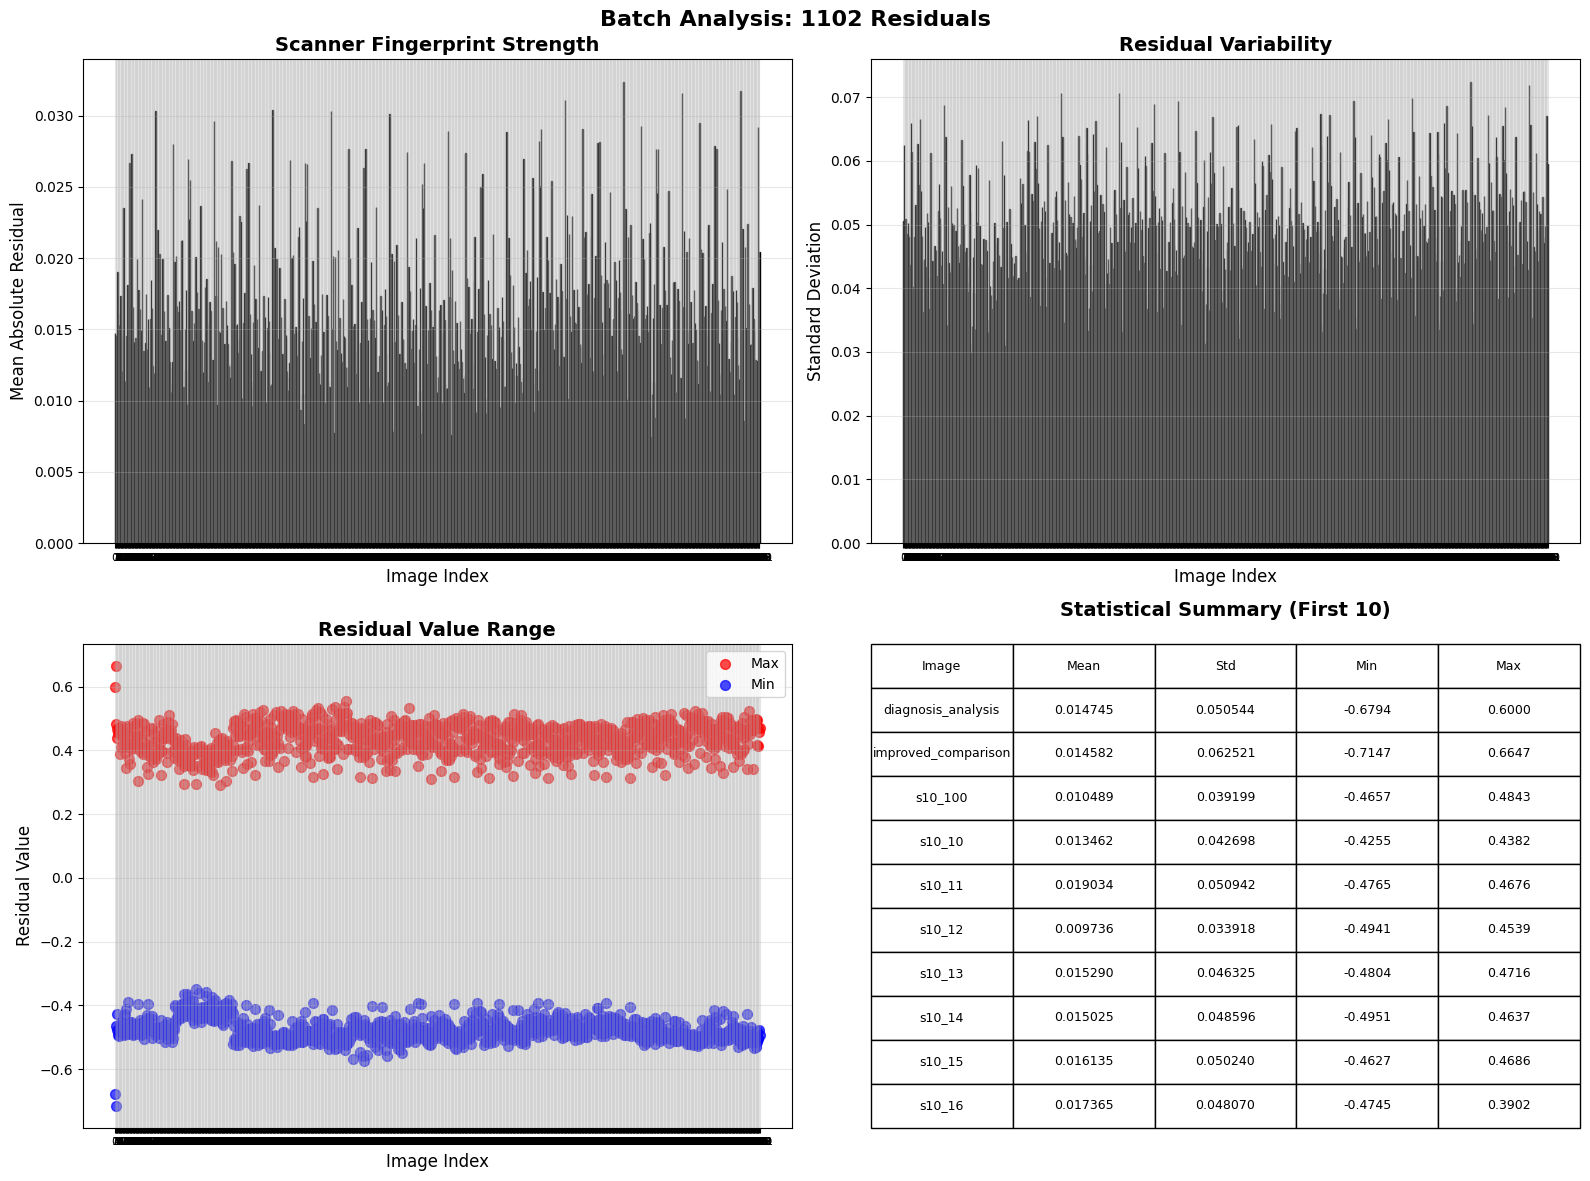

In [61]:
# ============================
# TraceFinder: Visualize all processed residuals
# ============================

from pathlib import Path

# Path to your processed residuals folder
residuals_folder = r"C:\Users\Sona\Downloads\TraceFinder_Processed"

# ----------------------------
# 1️⃣ Heatmap of residuals
# ----------------------------
visualize_fingerprint_heatmap(residuals_folder, max_images=30)  # You can increase max_images if needed

# ----------------------------
# 2️⃣ Batch statistics (Mean, Std, Min/Max)
# ----------------------------
visualize_batch_statistics(residuals_folder)


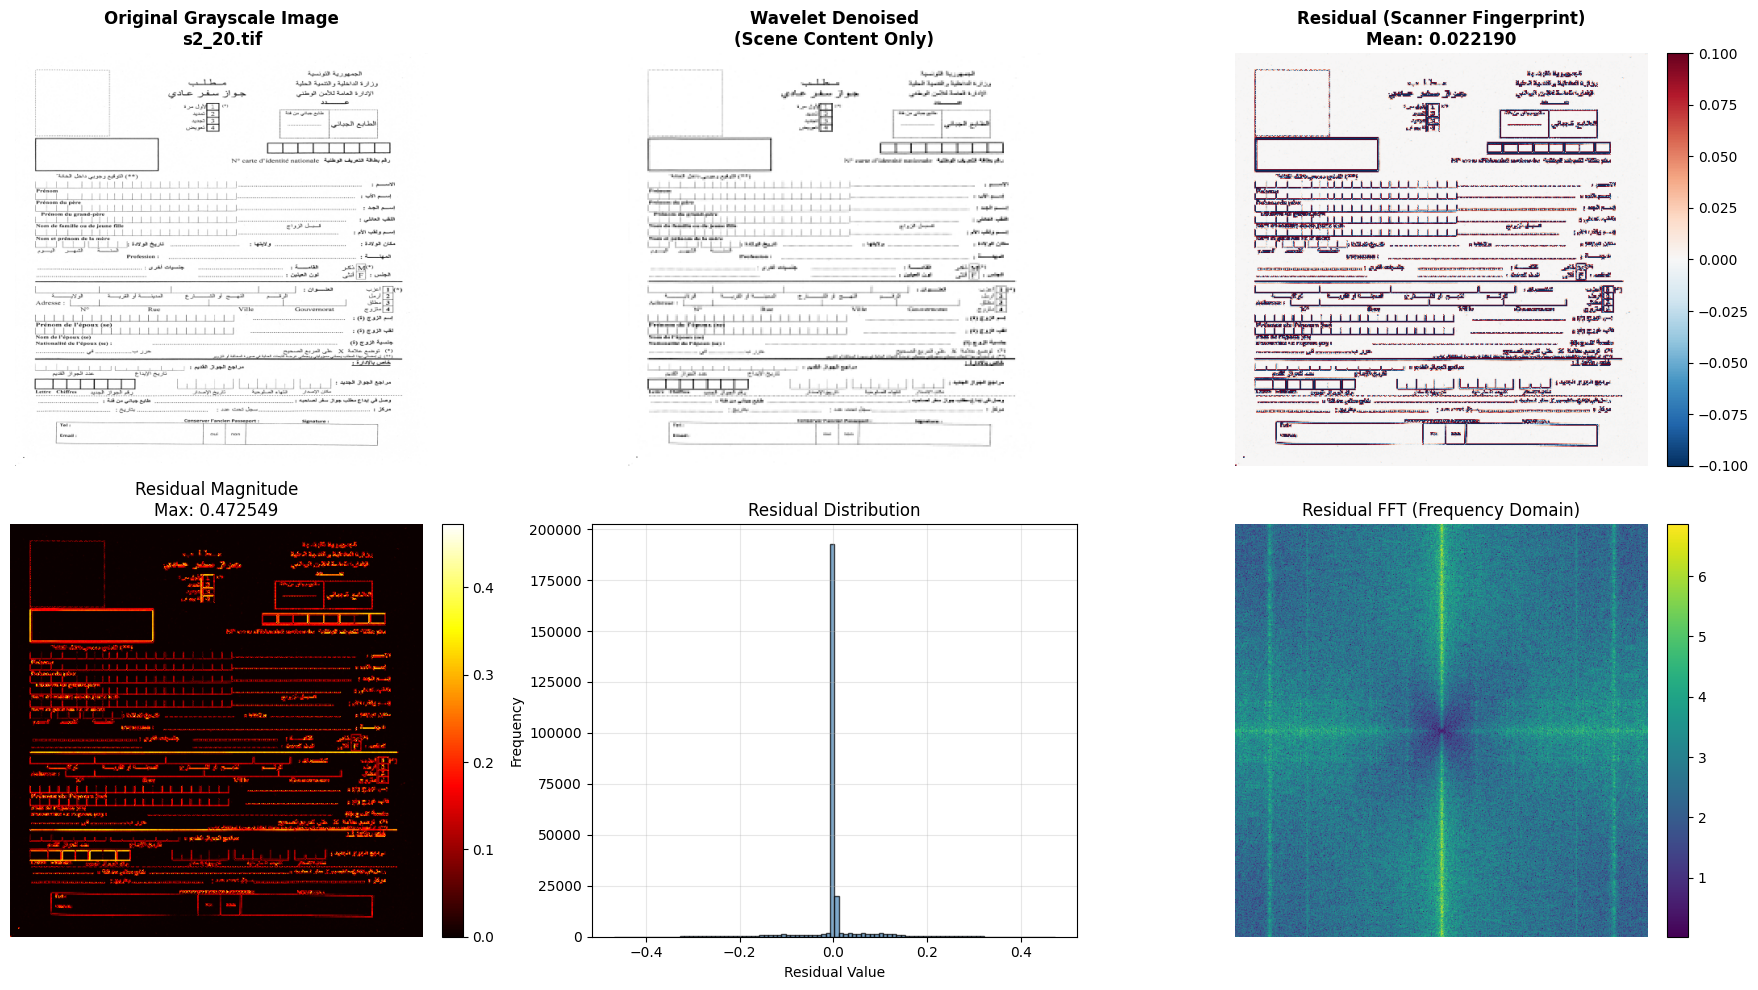

(array([[1.        , 1.        , 1.        , ..., 0.972549  , 1.        ,
         0.9882353 ],
        [1.        , 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ],
        [0.99607843, 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ],
        ...,
        [0.99607843, 0.99607843, 1.        , ..., 1.        , 1.        ,
         1.        ],
        [0.99215686, 1.        , 1.        , ..., 0.99607843, 1.        ,
         1.        ],
        [0.6901961 , 1.        , 1.        , ..., 1.        , 1.        ,
         1.        ]], shape=(512, 512), dtype=float32),
 array([[0.9999999 , 0.9999999 , 0.9999999 , ..., 0.99117637, 0.9970587 ,
         0.9970587 ],
        [0.9999999 , 0.9999999 , 0.9999999 , ..., 0.99117637, 0.9970587 ,
         0.9970587 ],
        [0.99901956, 0.99901956, 0.9999999 , ..., 0.9999999 , 0.9999999 ,
         0.9999999 ],
        ...,
        [0.9980391 , 0.9980391 , 0.99901956, ..., 0.9999999 , 0.9999999 ,
 

In [63]:
# Example: visualize one image from your processed folder
img_path = r"C:\Users\Sona\Downloads\official_document\Canon120-2\300\s2_20.tif"  # replace with any image name
process_image(img_path, output_dir=None, visualize=True)
